<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/Jhee/RF%26LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreProcessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile


In [2]:
!git clone -b main https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 781, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 781 (delta 82), reused 27 (delta 27), pack-reused 649 (from 4)
Receiving objects: 100% (781/781), 84.73 MiB | 8.18 MiB/s, done.
Resolving deltas: 100% (408/408), done.
Updating files: 100% (26/26), done.
/content/DATCapstone/data


In [3]:
from zipfile import ZipFile
import pandas as pd

# Explicitly extract data.csv from ZIP
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])


In [4]:
df

Date        Open        High         Low       Close    Volume  \
149  2021-09-30  140.983670  141.690258  138.648004  138.863907  89056700   
152  2021-10-01  139.256450  140.257452  136.518433  139.992477  94639600   
155  2021-10-04  139.119037  139.560665  135.694064  136.547852  98322000   
158  2021-10-05  136.891371  139.590139  136.763788  138.481186  80861100   
161  2021-10-06  136.871718  139.501783  135.792205  139.354584  83221100   
...         ...         ...         ...         ...         ...       ...   
8062 2025-01-27  394.799988  406.690002  389.000000  397.149994  58125500   
8072 2025-01-28  396.910004  400.589996  386.500000  398.089996  48910700   
8082 2025-01-29  395.209991  398.589996  384.480011  389.100006  68033600   
8092 2025-01-30  410.779999  412.500000  384.410004  400.279999  98092900   
8102 2025-01-31  401.529999  419.989990  401.339996  404.600006  83568200   

      Dividends  Stock Splits  GDP (Billions USD)  Unemployment Rate (%)  ...  \
149         0.0           0.0           23921.991                    4.7  ...   
152         0.0           0.0           24777.038                    4.5  ...   
155         0.0           0.0           24777.038                    4.5  ...   
158         0.0           0.0           24777.038                    4.5  ...   
161         0.0           0.0           24777.038                    4.5  ...   
...         ...           ...                 ...                    ...  ...   
8062        0.0           0.0           29723.864                    4.0  ...   
8072        0.0           0.0           29723.864                    4.0  ...   
8082        0.0           0.0           29723.864                    4.0  ...   
8092        0.0           0.0           29723.864                    4.0  ...   
8102        0.0           0.0           29723.864                    4.0  ...   

       emb_763   emb_764   emb_765   emb_766   emb_767  Target_1day  \
149        NaN       NaN       NaN       NaN       NaN     1.128571   
152        NaN       NaN       NaN       NaN       NaN    -3.444626   
155        NaN       NaN       NaN       NaN       NaN     1.933334   
158        NaN       NaN       NaN       NaN       NaN     0.873398   
161        NaN       NaN       NaN       NaN       NaN     1.265976   
...        ...       ...       ...       ...       ...          ...   
8062  1.174326 -0.262426  0.298183  0.182200  0.388200     0.940002   
8072  0.084330 -0.354550 -0.611864 -0.449780  0.584349    -8.989990   
8082  0.827862 -0.620100 -0.024186 -0.439615  0.781107    11.179993   
8092  1.383147 -0.616897 -0.145329 -0.418483  0.636253     4.320007   
8102  0.658588 -0.312093 -0.158066 -0.211410  0.834208          NaN   

      Target_1week  Target_1month  Target_1year  Ticker  
149       1.756653      10.863785      9.008606    AAPL  
152       0.245331       7.016815      0.616699    AAPL  
155       3.601639       9.637100     -0.162491    AAPL  
158       0.392532       8.744034      2.098389    AAPL  
161      -1.069687       9.313263      4.827057    AAPL  
...            ...            ...           ...     ...  
8062           NaN            NaN           NaN    TSLA  
8072           NaN            NaN           NaN    TSLA  
8082           NaN            NaN           NaN    TSLA  
8092           NaN            NaN           NaN    TSLA  
8102           NaN            NaN           NaN    TSLA  

[8103 rows x 817 columns]

In [5]:
!pip install tensorflow


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Fill missing values
emb_cols = [col for col in df.columns if col.startswith('emb_')]
target_cols = [col for col in df.columns if 'Target' in col]
non_target_cols = [col for col in df.columns if col not in target_cols + ['Date', 'Ticker']]

df.loc[:, emb_cols] = df[emb_cols].fillna(0)
df.loc[:, non_target_cols] = df[non_target_cols].fillna(0)
df = df.dropna(subset=target_cols)

# Sequence creation
def create_sequences(X, y, look_back=30):
    Xs, ys = [], []
    for i in range(look_back, len(X)):
        Xs.append(X[i - look_back:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# Main training & evaluation function
def run_lstm_by_ticker(df, ticker, target, look_back=30, epochs=20, batch_size=32):
    df_ticker = df[df['Ticker'] == ticker].copy().sort_values(by='Date')
    df_ticker = df_ticker.dropna(subset=[target])


    feature_cols = [col for col in df_ticker.columns if 'Target' not in col and col not in ['Date', 'Ticker']]
    df_ticker[feature_cols] = df_ticker[feature_cols].fillna(0)

    X = df_ticker[feature_cols].values
    y = df_ticker[target].values

    if len(X) <= look_back + 30:
        print(f"[{ticker}] {target}: Not enough data. Skipping.")
        return

    # Train/Validation/Test split
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, look_back)
    X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, look_back)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, look_back)

    if len(X_train_seq) == 0 or len(X_val_seq) == 0 or len(X_test_seq) == 0:
        print(f"[{ticker}] {target}: Not enough sequence data. Skipping.")
        return

    # Define and train model
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=[early_stop],
        verbose=0
    )

    # Predict and evaluate
    y_pred = model.predict(X_test_seq).flatten()
    mae = mean_absolute_error(y_test_seq, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    r2 = r2_score(y_test_seq, y_pred)

    print(f"\n[{ticker}] Target: {target}")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²   : {r2:.4f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_seq, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"LSTM Prediction – {ticker} | {target}")
    plt.xlabel('Sample Index')
    plt.ylabel('Target')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save only MSFT plots
    if ticker == 'MSFT':
        filename = f'msft_lstm_{target}.png'
        plt.savefig(filename)

    plt.show()

    return history


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

[MSFT] Target: Target_1day
MAE : 6.7452
RMSE: 8.5819
R²   : -2.8547


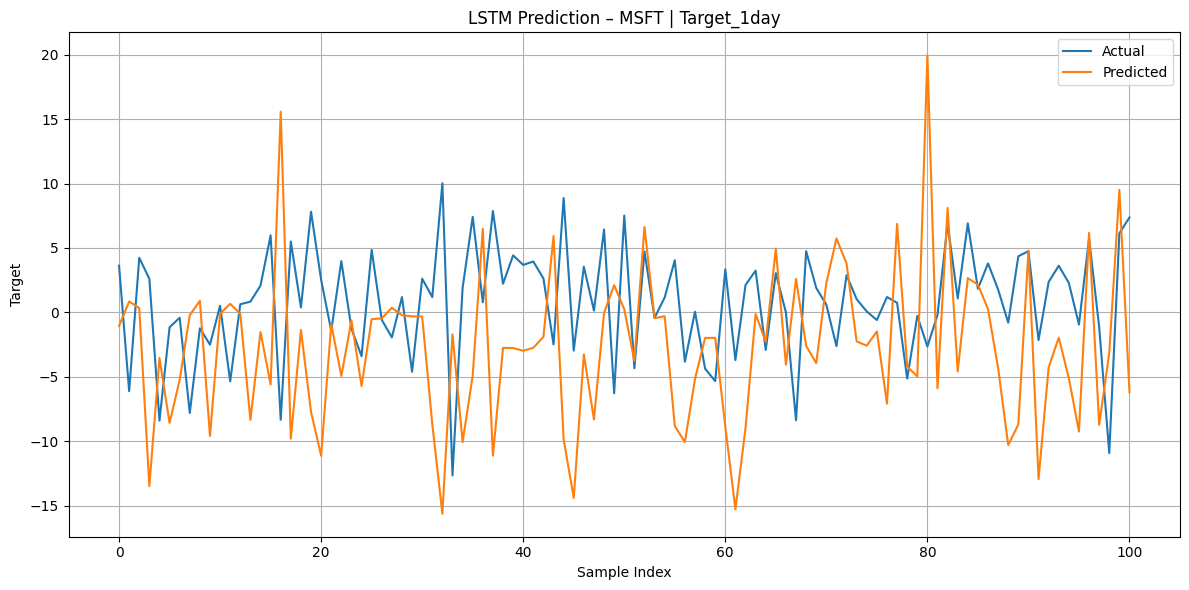

Epoch 1: Train Loss = 31.6402 | Validation Loss = 73.9484
Epoch 2: Train Loss = 26.8428 | Validation Loss = 46.0590
Epoch 3: Train Loss = 24.6549 | Validation Loss = 56.1263
Epoch 4: Train Loss = 23.1846 | Validation Loss = 62.6377
Epoch 5: Train Loss = 22.9790 | Validation Loss = 62.8806


In [42]:
# Validation 성능 확인용
history = run_lstm_by_ticker(df, 'MSFT', 'Target_1day')

# history가 제대로 반환되었는지 확인
if history:
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    for i, (train_l, val_l) in enumerate(zip(train_losses, val_losses), 1):
        print(f"Epoch {i}: Train Loss = {train_l:.4f} | Validation Loss = {val_l:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

[MSFT] Target: Target_1week
MAE : 42.3078
RMSE: 60.8742
R²   : -46.2249


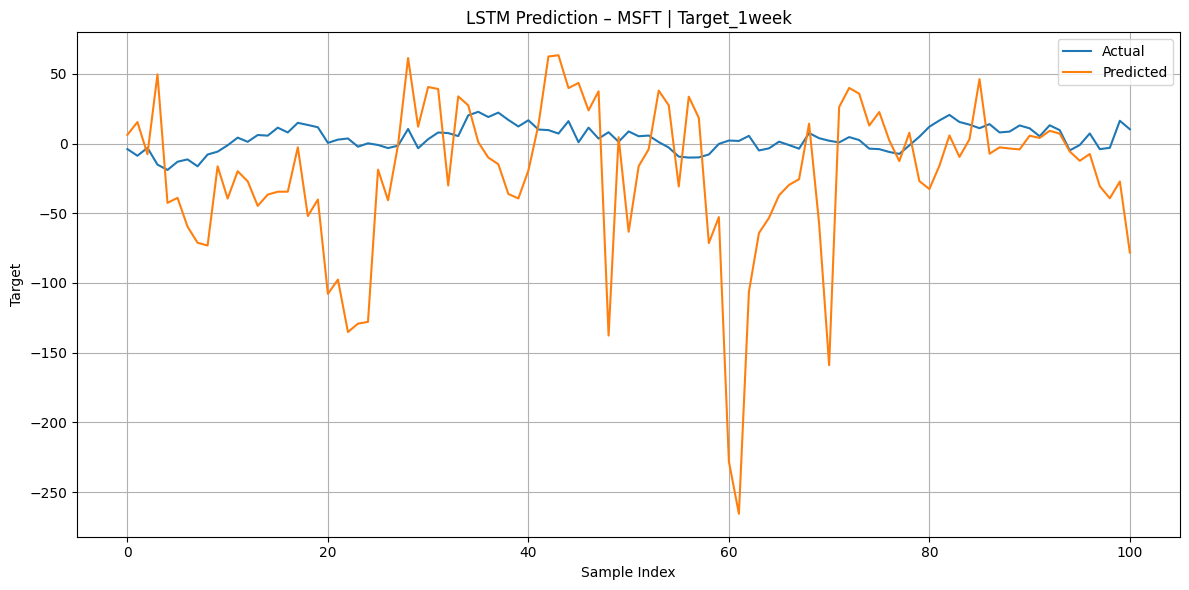

Epoch 1: Train Loss = 134.3568 | Validation Loss = 391.6428
Epoch 2: Train Loss = 116.8131 | Validation Loss = 208.2880
Epoch 3: Train Loss = 97.2609 | Validation Loss = 248.5775
Epoch 4: Train Loss = 82.2318 | Validation Loss = 236.8388
Epoch 5: Train Loss = 78.1824 | Validation Loss = 179.4274
Epoch 6: Train Loss = 301.1995 | Validation Loss = 874.1898
Epoch 7: Train Loss = 118.2804 | Validation Loss = 1068.1881
Epoch 8: Train Loss = 105.7471 | Validation Loss = 875.7012


In [41]:
history = run_lstm_by_ticker(df, 'MSFT', 'Target_1week')

if history:
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    for i, (train_l, val_l) in enumerate(zip(train_losses, val_losses), 1):
        print(f"Epoch {i}: Train Loss = {train_l:.4f} | Validation Loss = {val_l:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step

[MSFT] Target: Target_1month
MAE : 27.2391
RMSE: 34.1130
R²   : -3.4361


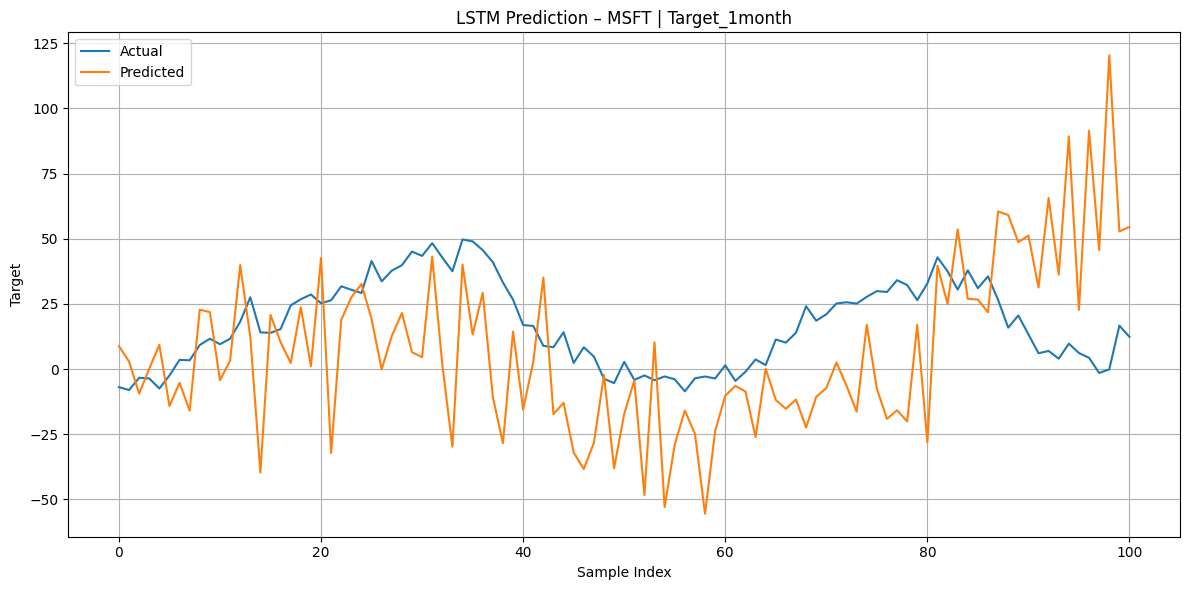

Epoch 1: Train Loss = 312.0500 | Validation Loss = 1358.3160
Epoch 2: Train Loss = 172.9044 | Validation Loss = 1684.1514
Epoch 3: Train Loss = 148.0784 | Validation Loss = 1494.6011
Epoch 4: Train Loss = 102.6638 | Validation Loss = 1715.9554


In [43]:
history = run_lstm_by_ticker(df, 'MSFT', 'Target_1month')

if history:
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    for i, (train_l, val_l) in enumerate(zip(train_losses, val_losses), 1):
        print(f"Epoch {i}: Train Loss = {train_l:.4f} | Validation Loss = {val_l:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

[MSFT] Target: Target_1year
MAE : 142.4675
RMSE: 185.4855
R²   : -49.5247


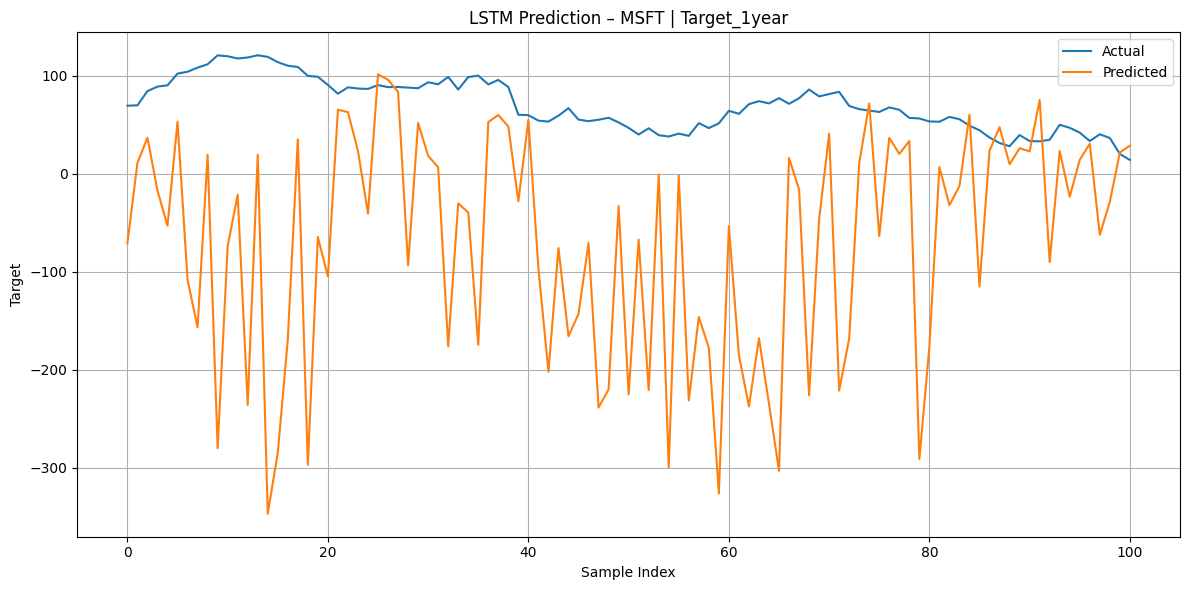

Epoch 1: Train Loss = 4284.1348 | Validation Loss = 6816.9277
Epoch 2: Train Loss = 1718.7346 | Validation Loss = 9671.5605
Epoch 3: Train Loss = 5309.2480 | Validation Loss = 9495.3896
Epoch 4: Train Loss = 10639.2129 | Validation Loss = 9654.3750


In [44]:
history = run_lstm_by_ticker(df, 'MSFT', 'Target_1year')

if history:
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    for i, (train_l, val_l) in enumerate(zip(train_losses, val_losses), 1):
        print(f"Epoch {i}: Train Loss = {train_l:.4f} | Validation Loss = {val_l:.4f}")


In [39]:
print("Date dtype:", df['Date'].dtype)
print("Ticker column exists:", 'Ticker' in df.columns)
print("Target columns:", [col for col in df.columns if 'Target' in col])
print("Missing values (top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))
print("Column types:")
print(df.dtypes.value_counts())


Date dtype: datetime64[ns]
Ticker column exists: True
Target columns: ['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']
Missing values (top 10):
Ticker     0
emb_756    0
emb_755    0
emb_754    0
emb_753    0
emb_752    0
emb_751    0
emb_750    0
emb_749    0
emb_748    0
dtype: int64
Column types:
float64           814
datetime64[ns]      1
int64               1
object              1
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step

[AAPL] Target: Target_1day
MAE : 3.0233
RMSE: 3.7217
R²   : -2.3116


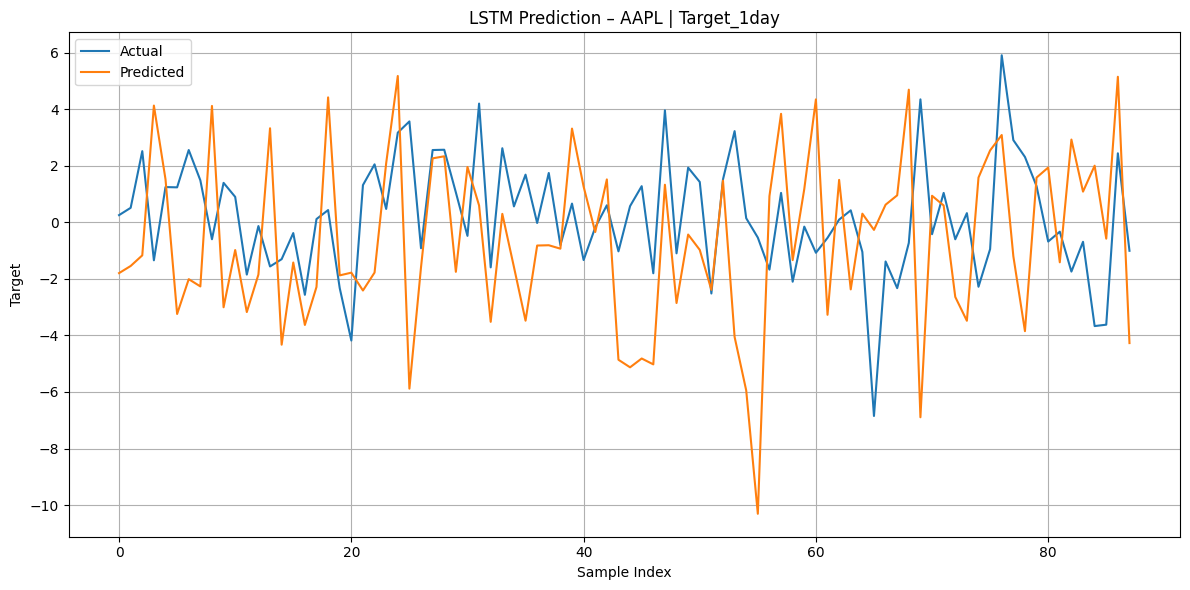

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

[AAPL] Target: Target_1week
MAE : 7.3400
RMSE: 9.2196
R²   : -1.8618


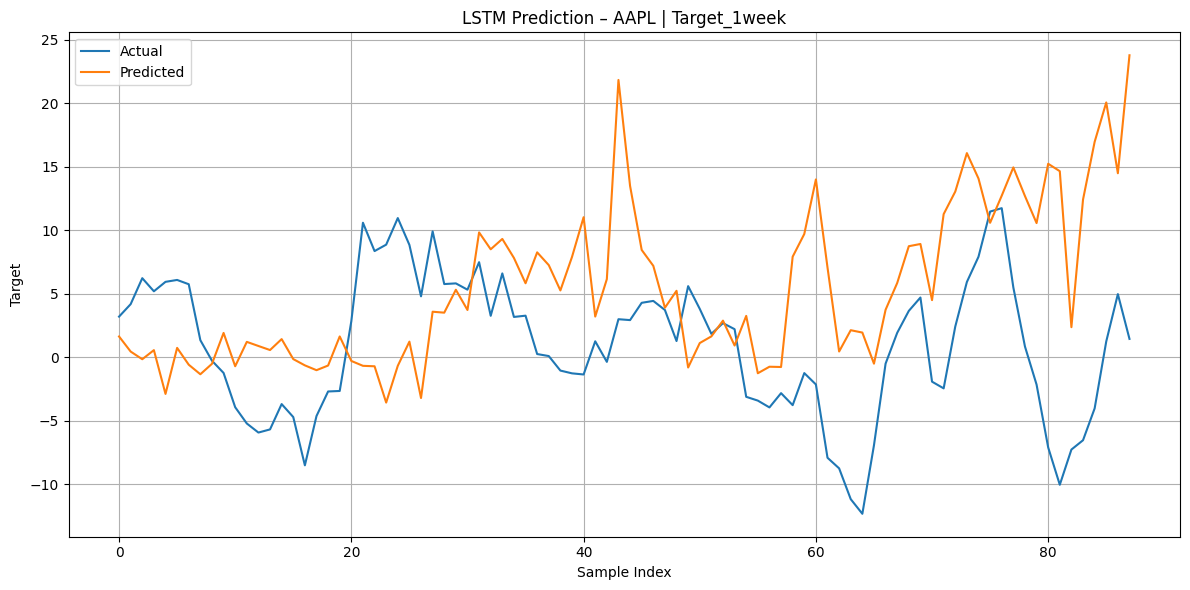

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step

[AAPL] Target: Target_1month
MAE : 26.2607
RMSE: 31.7101
R²   : -10.7744


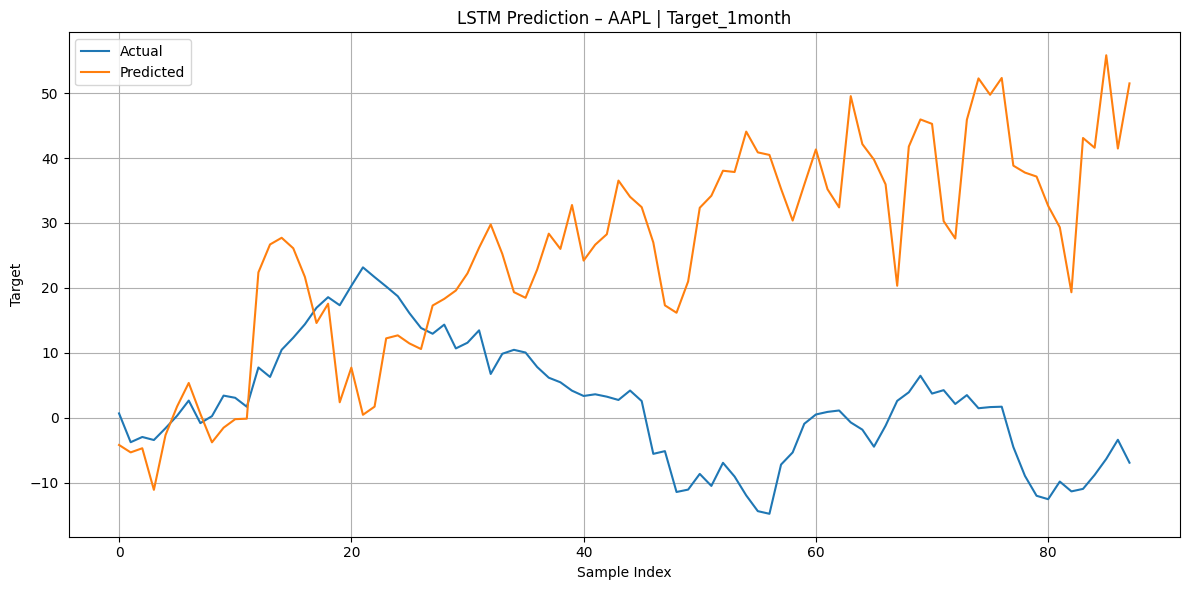

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

[AAPL] Target: Target_1year
MAE : 23.2152
RMSE: 26.2853
R²   : -6.6182


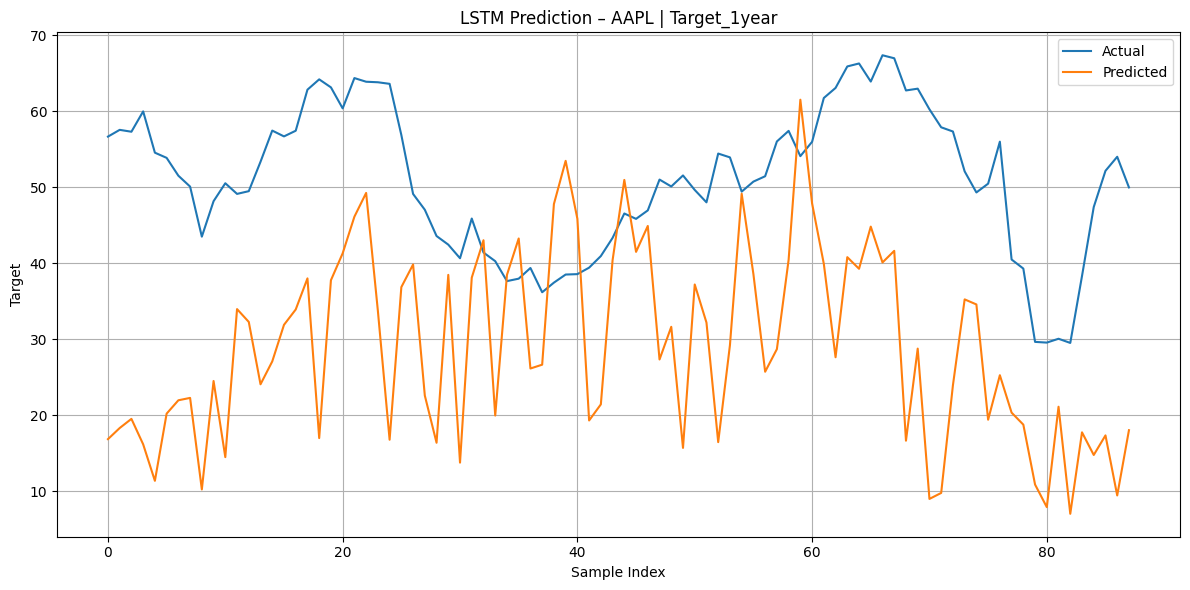

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

[AMD] Target: Target_1day
MAE : 9.0272
RMSE: 15.9836
R²   : -15.4514


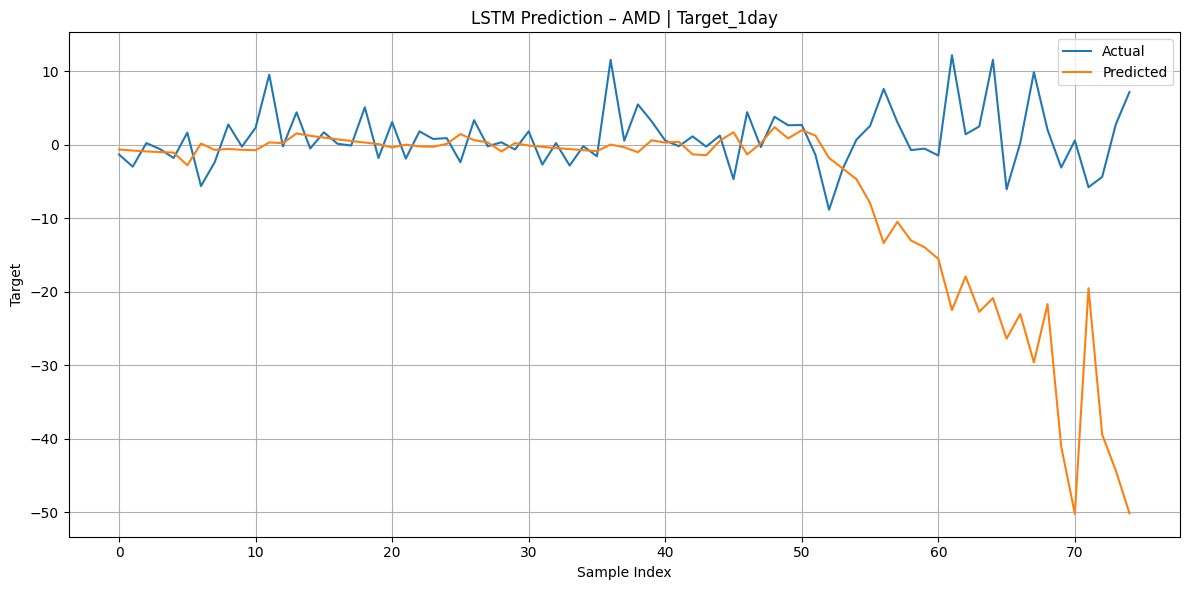

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

[AMD] Target: Target_1week
MAE : 7.1435
RMSE: 8.7795
R²   : -0.0860


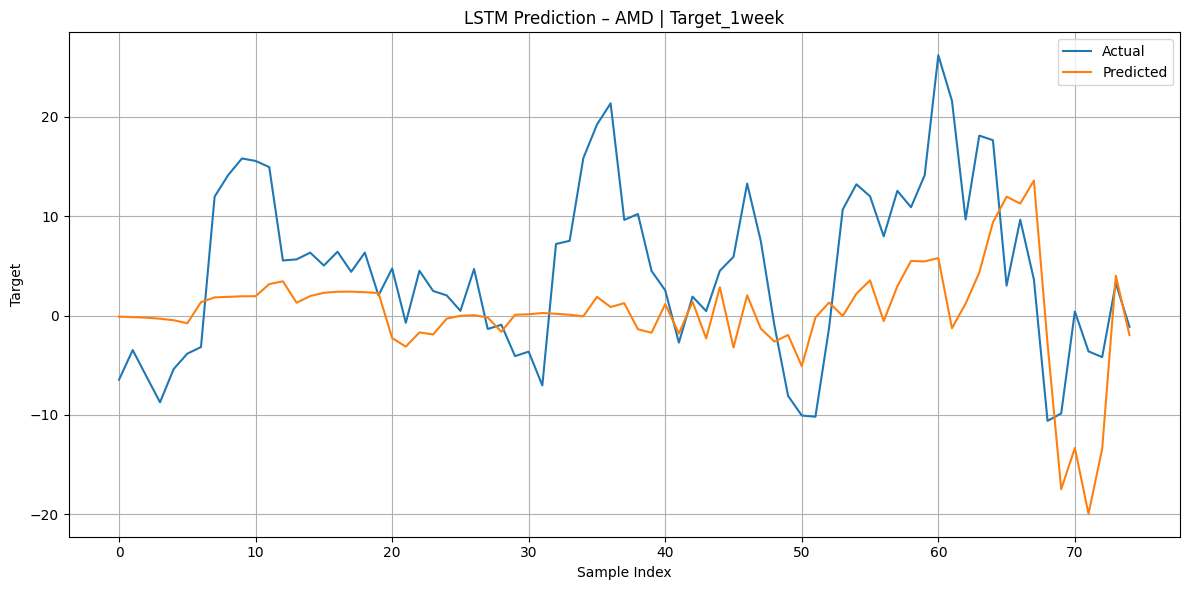

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step

[AMD] Target: Target_1month
MAE : 27.2854
RMSE: 30.7499
R²   : -8.3639


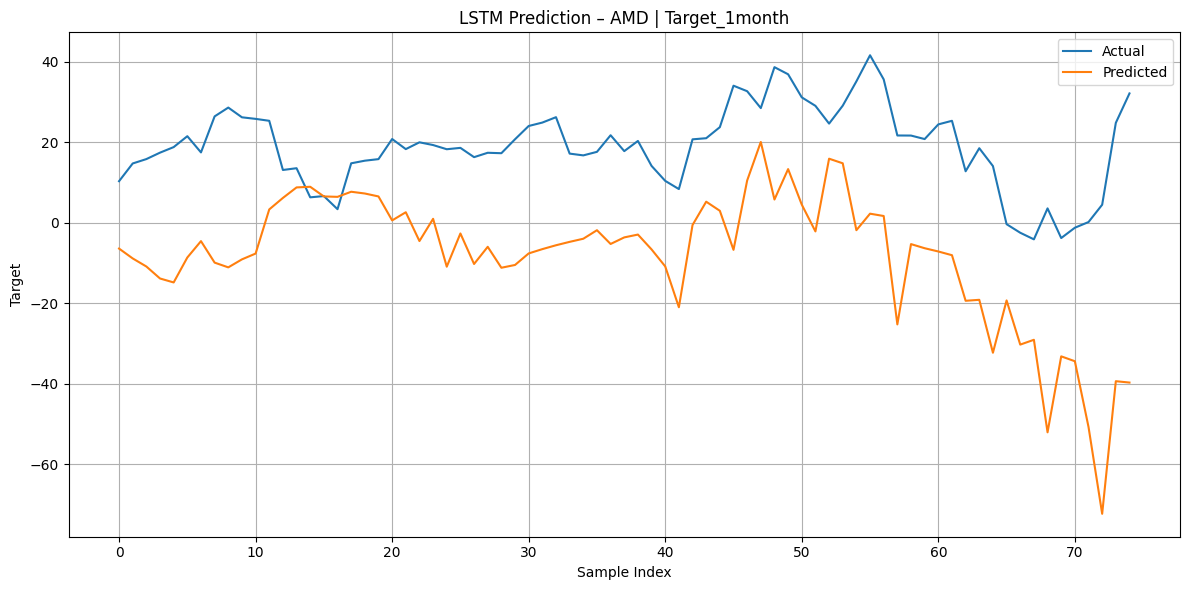

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

[AMD] Target: Target_1year
MAE : 51.0993
RMSE: 63.3810
R²   : -2.0844


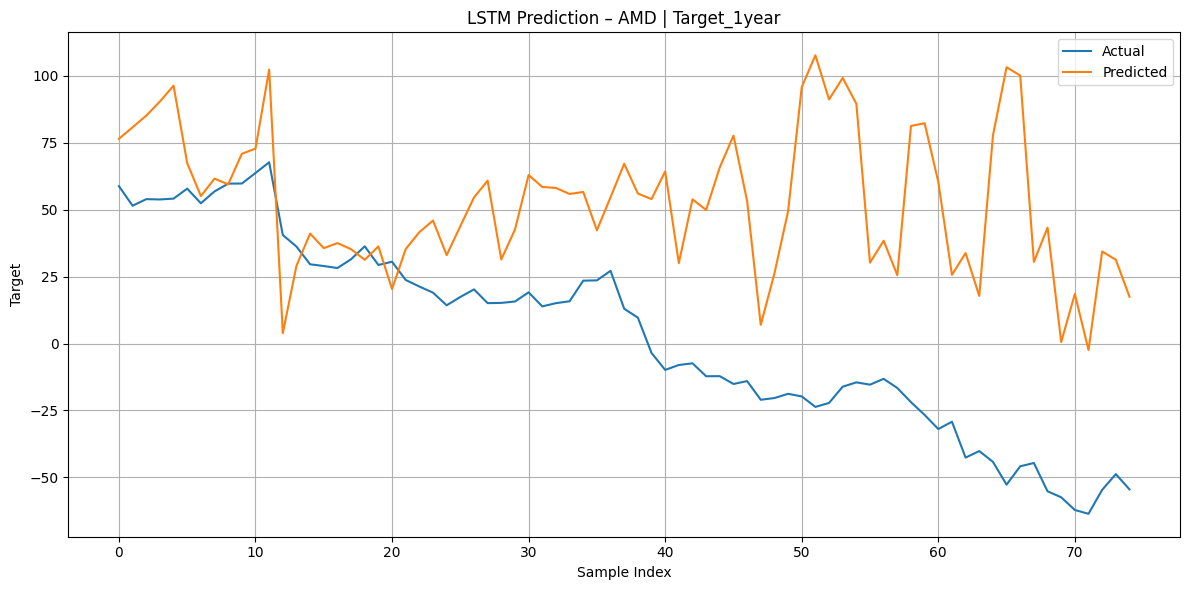

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step

[AMZN] Target: Target_1day
MAE : 2.3928
RMSE: 3.3243
R²   : -0.4873


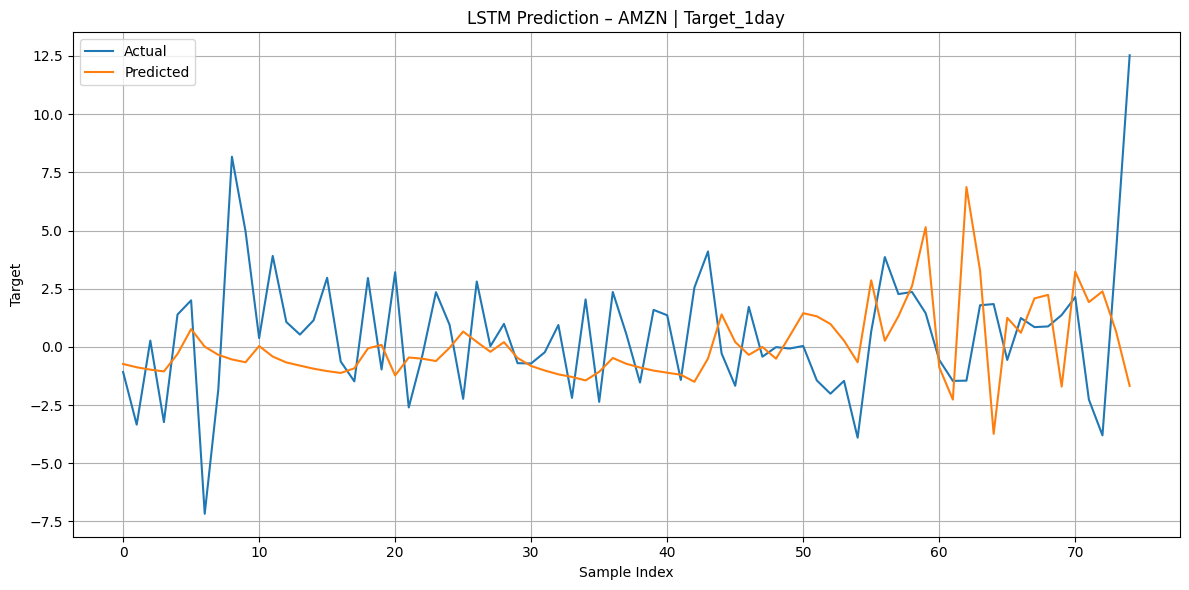

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

[AMZN] Target: Target_1week
MAE : 7.1889
RMSE: 10.8505
R²   : -3.1650


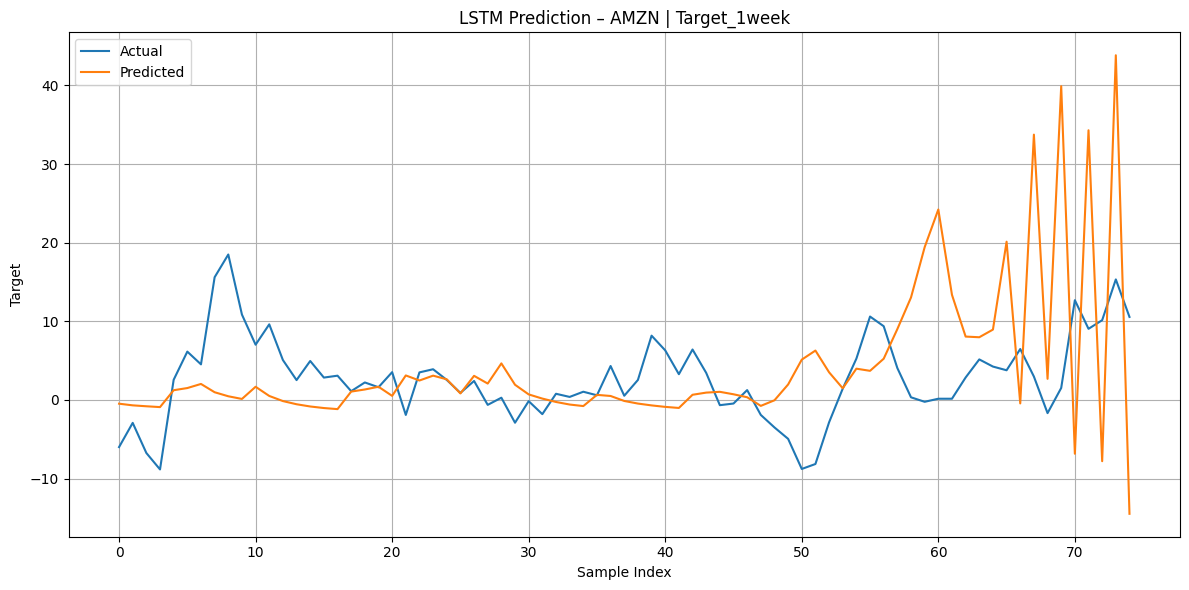

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

[AMZN] Target: Target_1month
MAE : 9.3286
RMSE: 11.3124
R²   : -1.5636


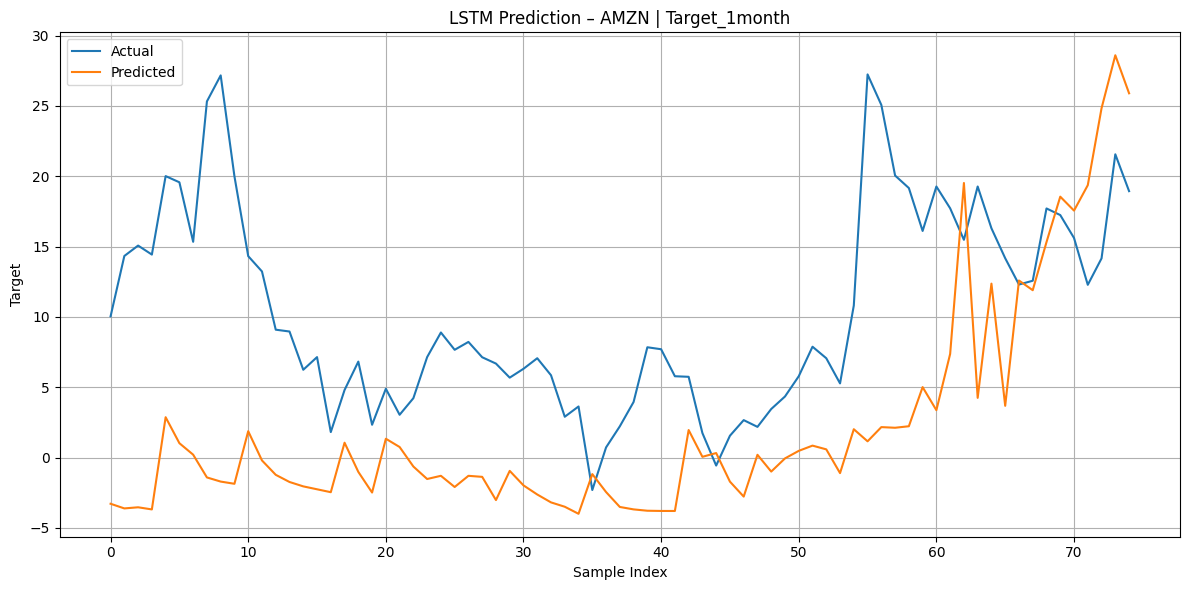

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

[AMZN] Target: Target_1year
MAE : 37.7634
RMSE: 41.0982
R²   : -21.0321


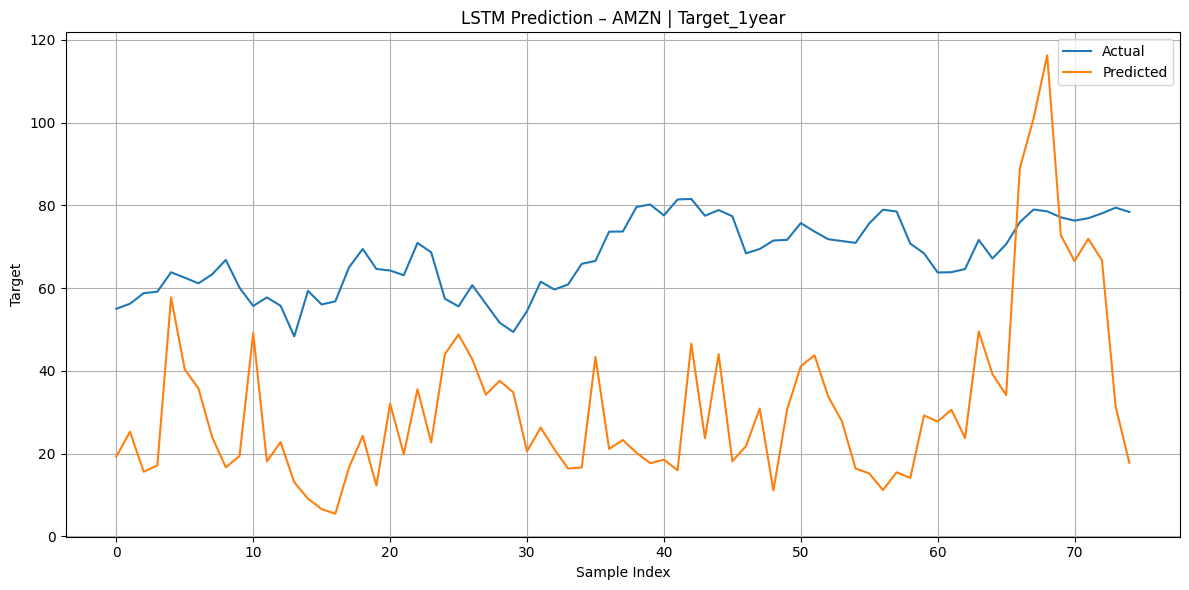

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

[AVGO] Target: Target_1day
MAE : 3.0472
RMSE: 4.4084
R²   : -3.6664


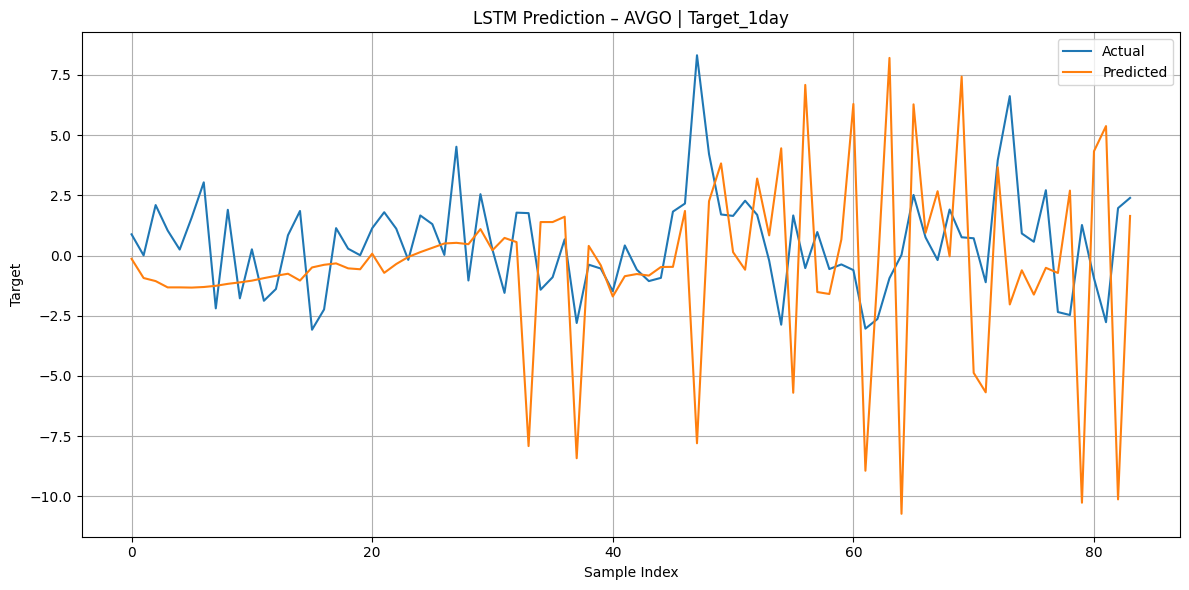

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

[AVGO] Target: Target_1week
MAE : 7.7935
RMSE: 9.6637
R²   : -1.6775


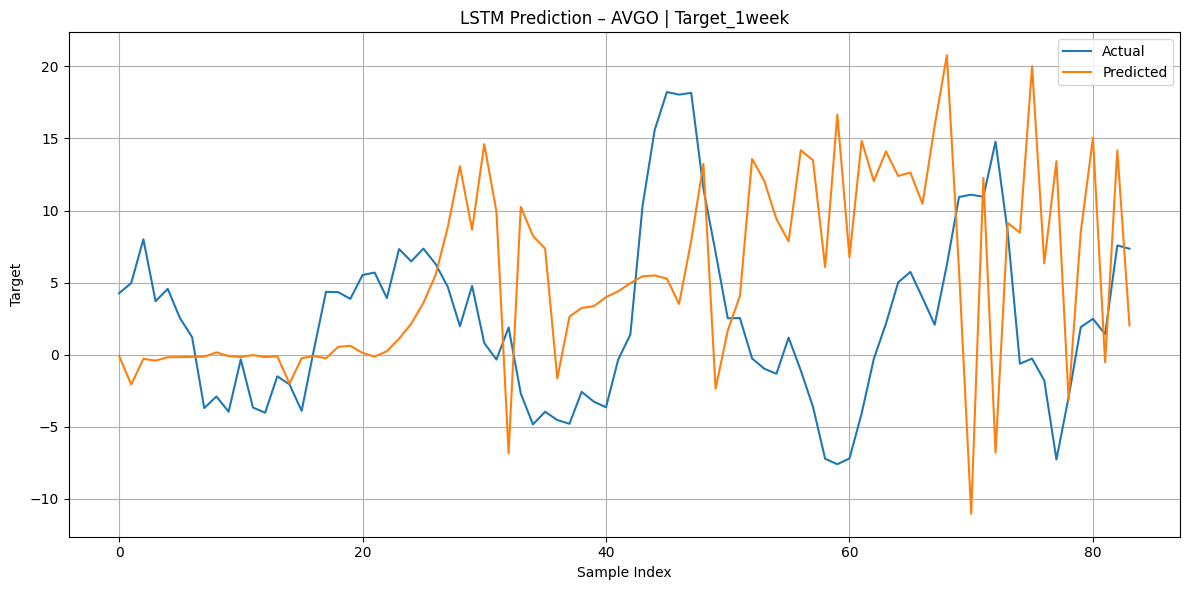

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

[AVGO] Target: Target_1month
MAE : 6.6943
RMSE: 8.0098
R²   : -0.9940


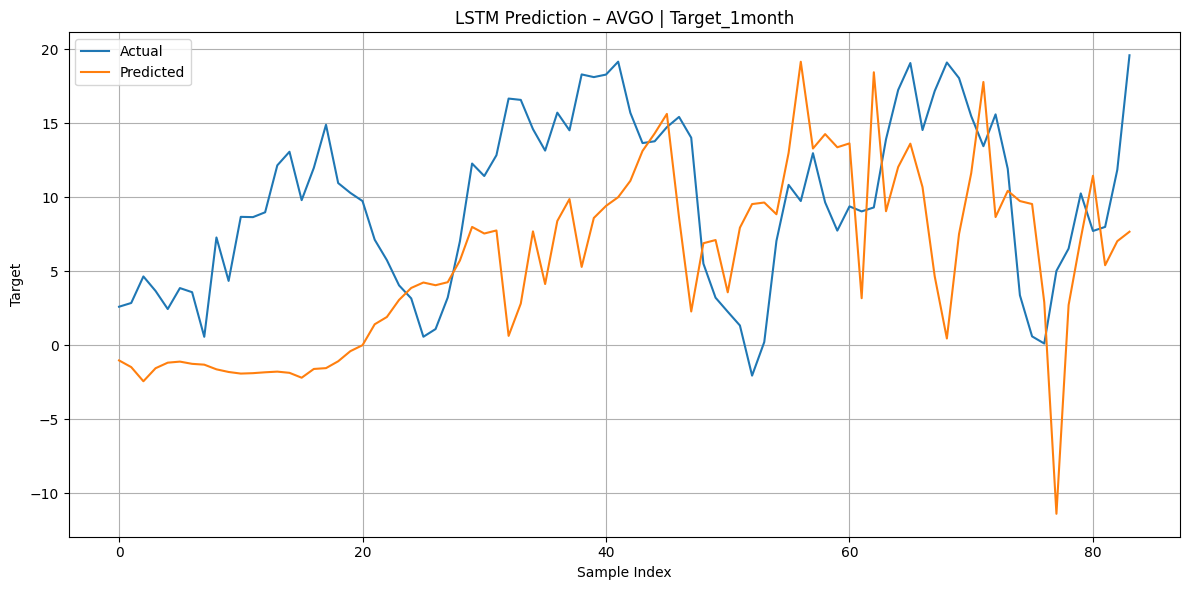

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

[AVGO] Target: Target_1year
MAE : 92.8874
RMSE: 112.9583
R²   : -31.4941


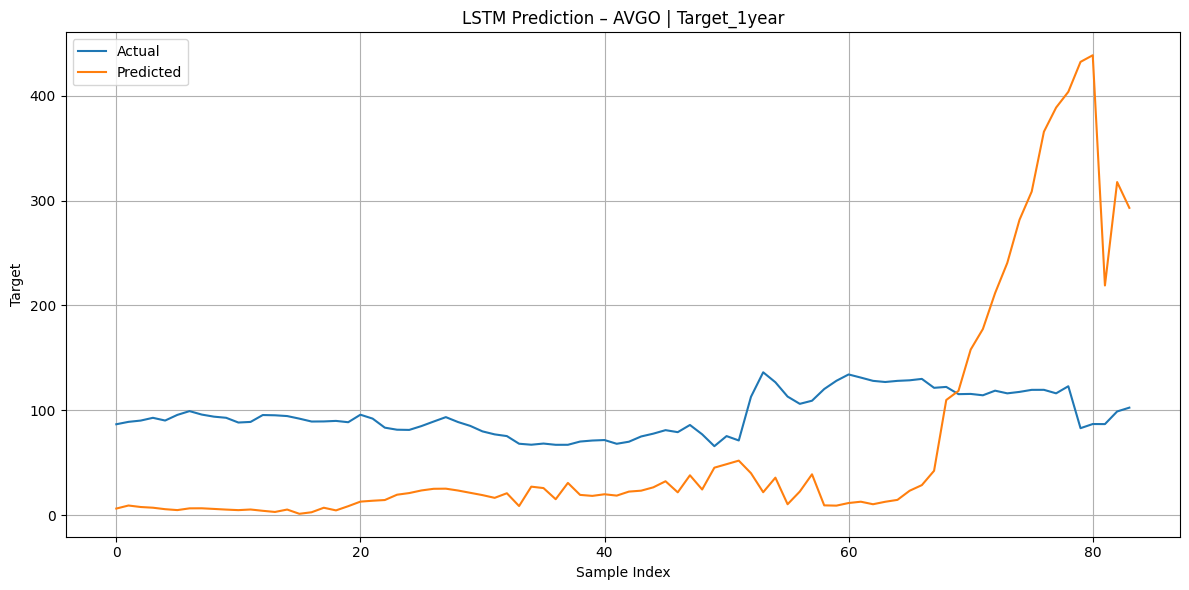

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

[GOOGL] Target: Target_1day
MAE : 13.6854
RMSE: 27.5569
R²   : -106.6659


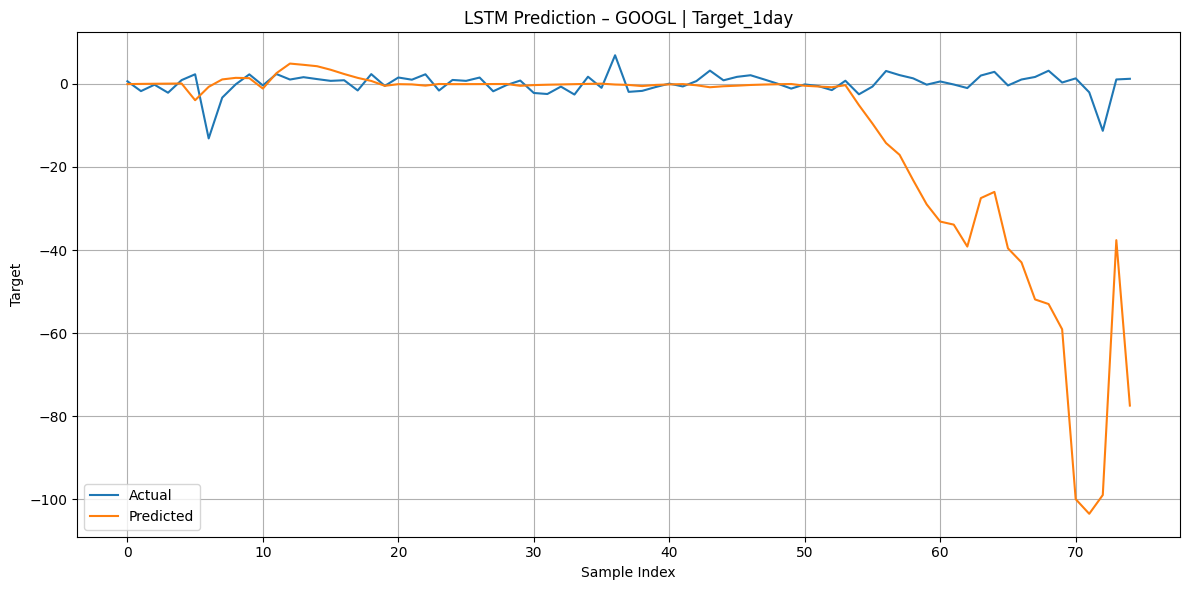

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

[GOOGL] Target: Target_1week
MAE : 22.6497
RMSE: 39.9384
R²   : -43.5703


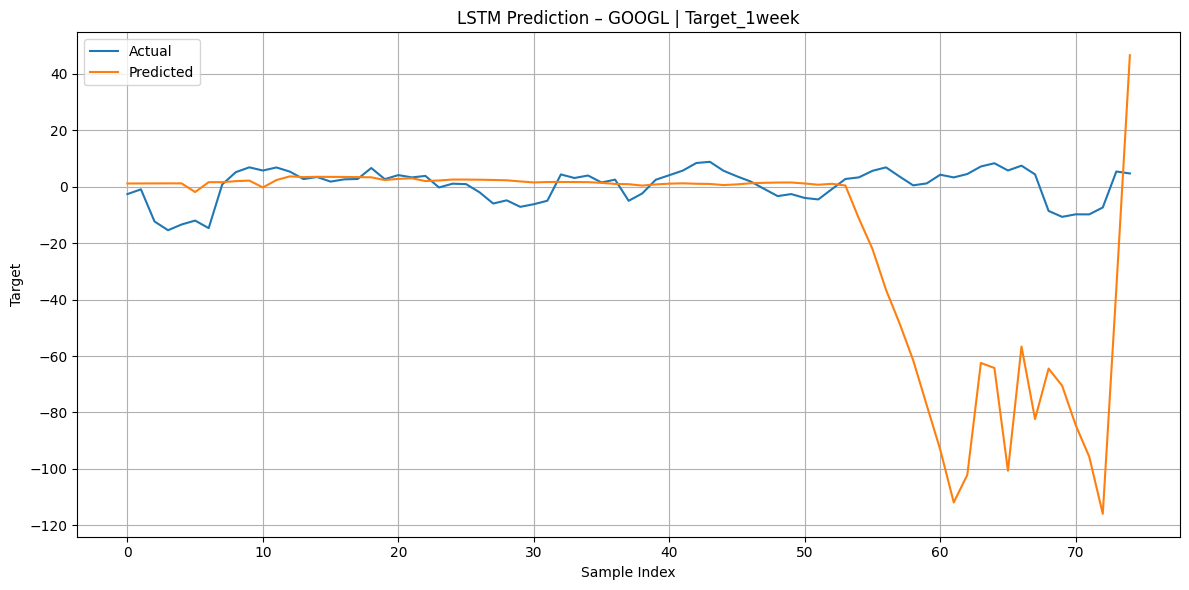

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

[GOOGL] Target: Target_1month
MAE : 18.9838
RMSE: 76.7124
R²   : -137.9867


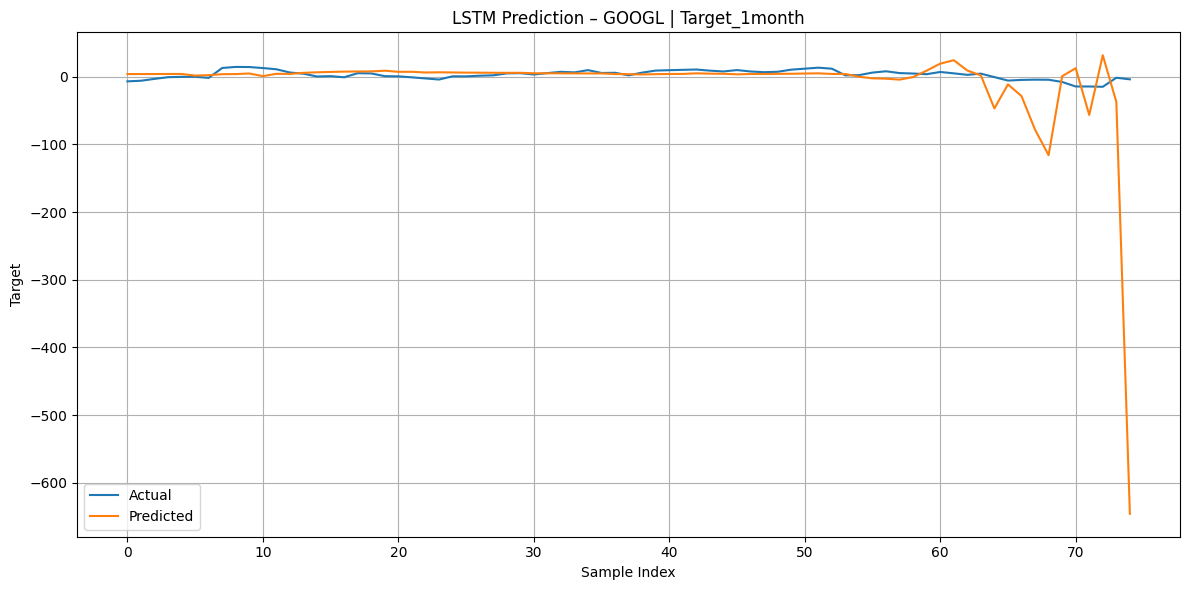

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

[GOOGL] Target: Target_1year
MAE : 100.2135
RMSE: 153.3496
R²   : -247.2559


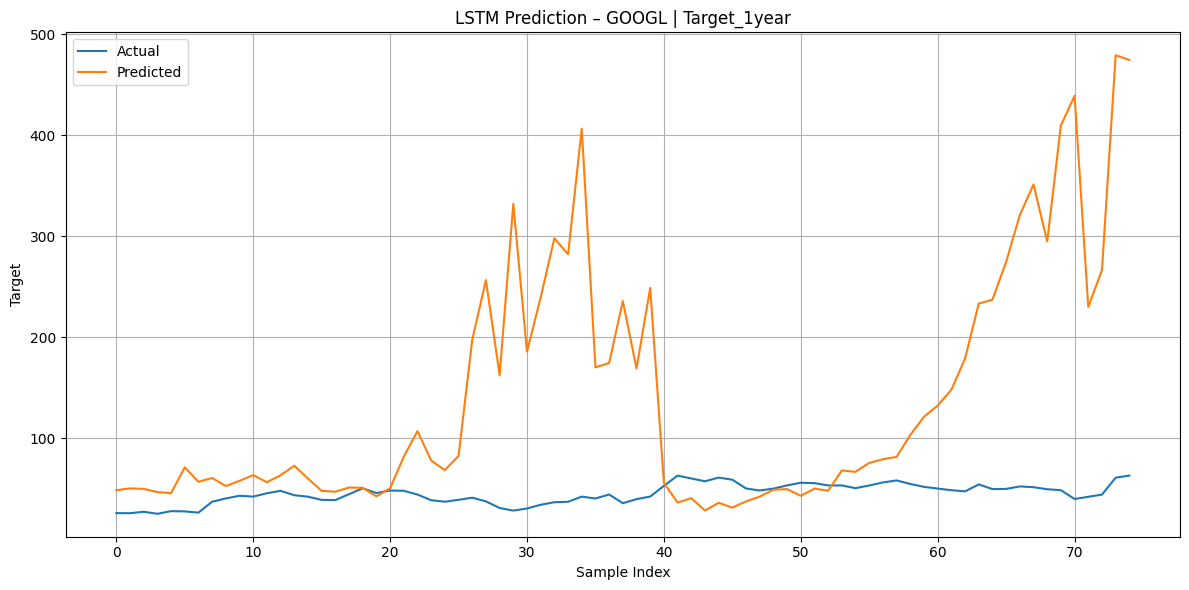

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step

[META] Target: Target_1day
MAE : 5.5679
RMSE: 10.2925
R²   : 0.0310


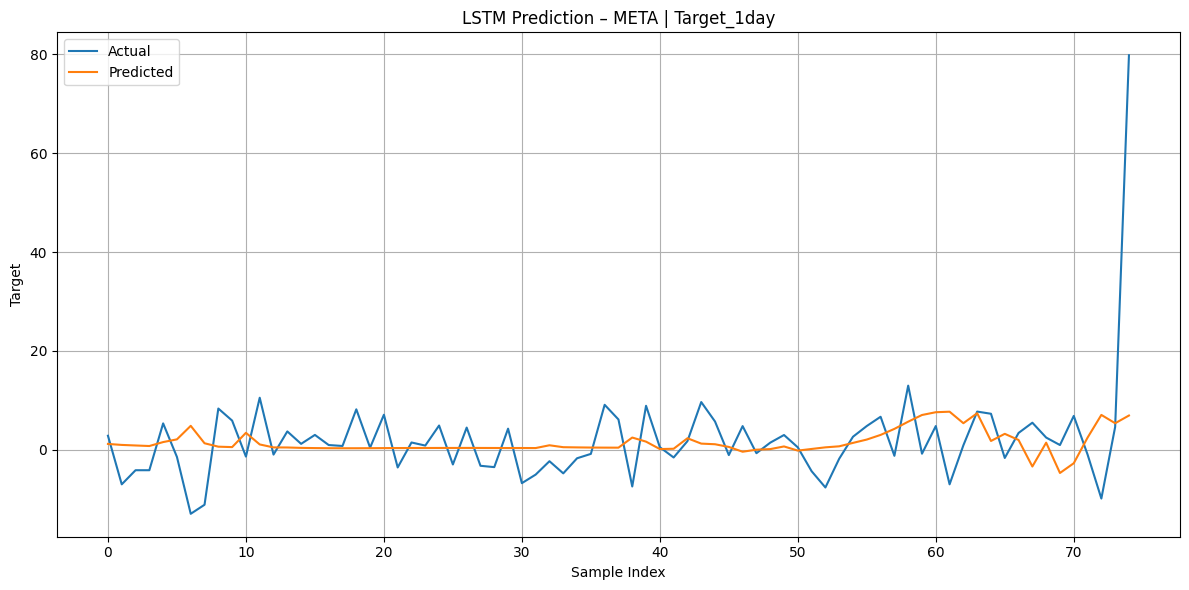

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

[META] Target: Target_1week
MAE : 14.6991
RMSE: 21.5484
R²   : -0.1659


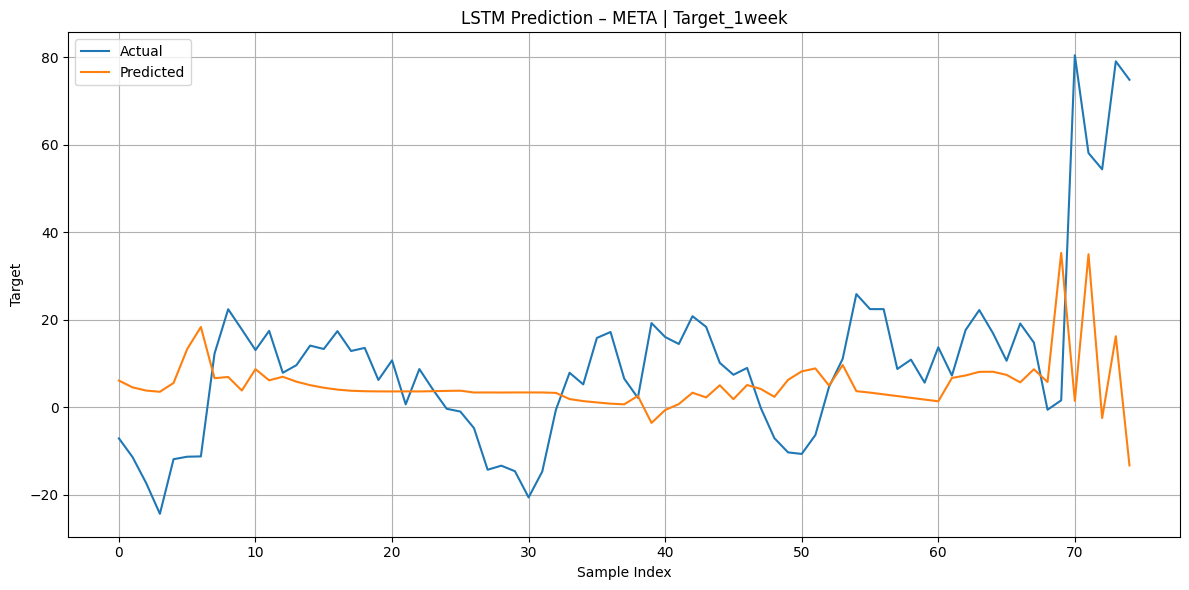

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

[META] Target: Target_1month
MAE : 39.0712
RMSE: 51.8430
R²   : -1.1594


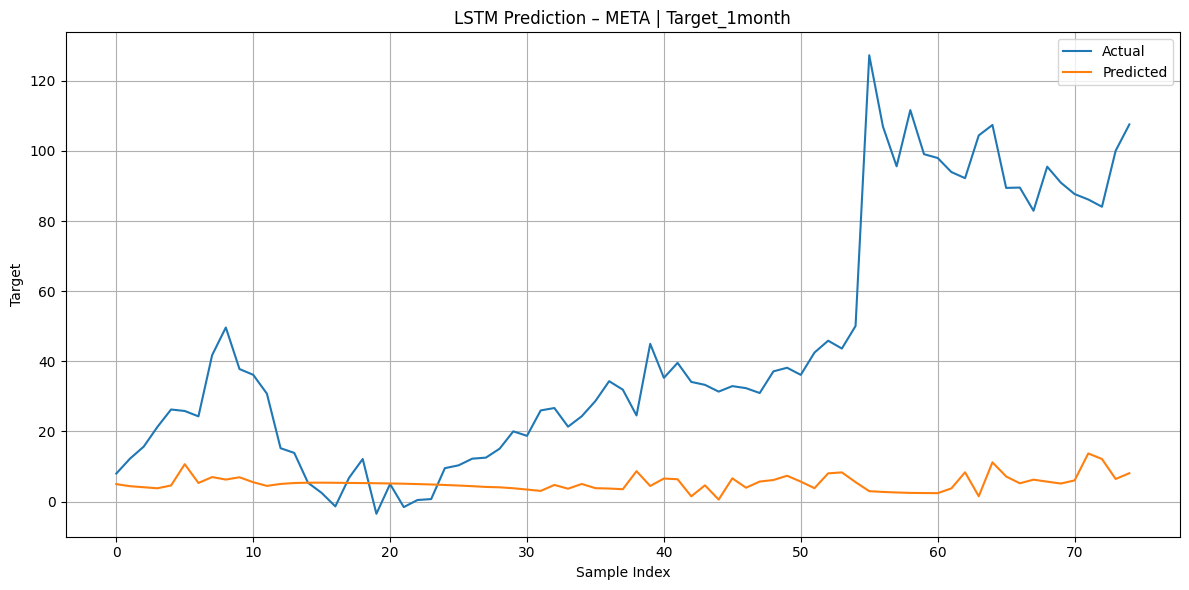

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

[META] Target: Target_1year
MAE : 145.0191
RMSE: 152.8574
R²   : -49.6965


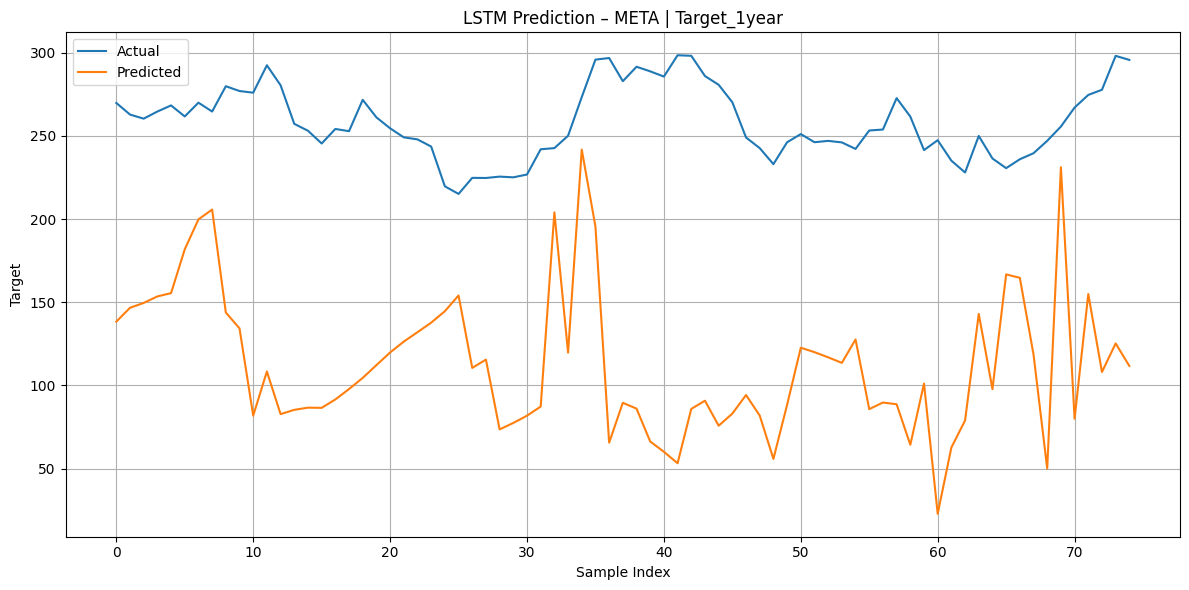

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

[MSFT] Target: Target_1day
MAE : 29.9828
RMSE: 55.7894
R²   : -161.9031


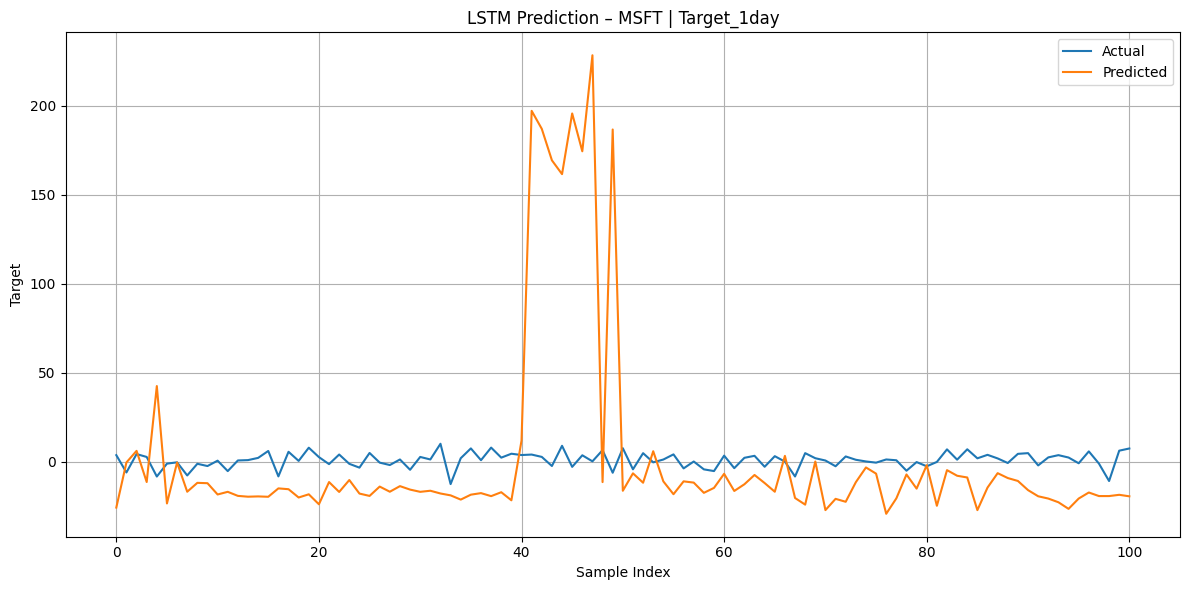

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step

[MSFT] Target: Target_1week
MAE : 17.5518
RMSE: 21.5746
R²   : -4.9318


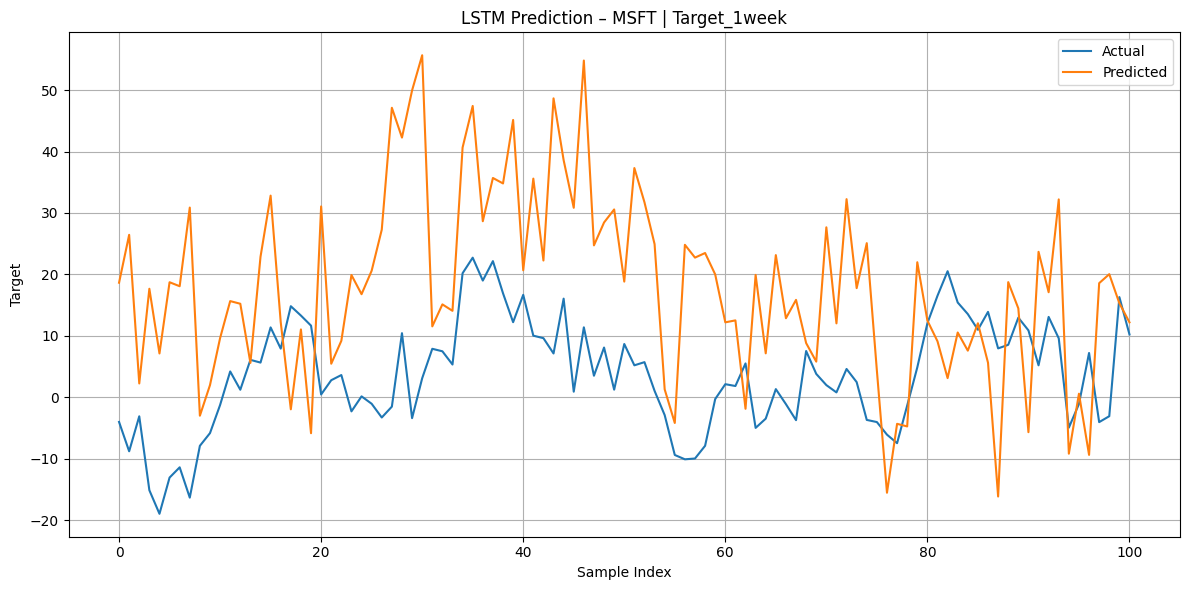

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

[MSFT] Target: Target_1month
MAE : 98.4662
RMSE: 118.9666
R²   : -52.9525


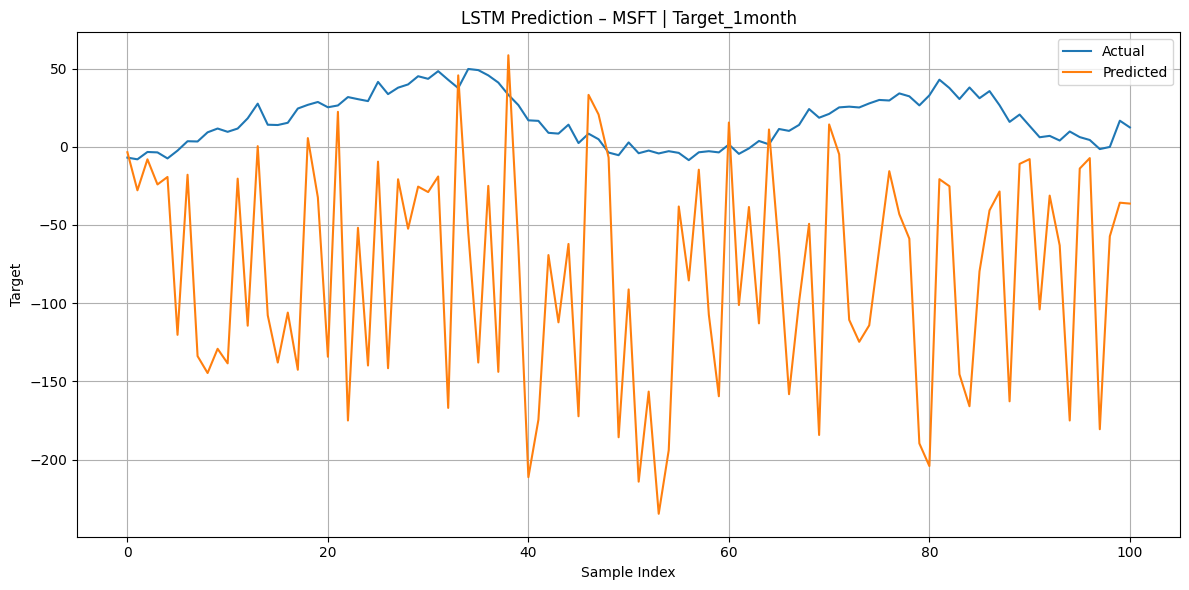

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

[MSFT] Target: Target_1year
MAE : 25.1201
RMSE: 33.0756
R²   : -0.6066


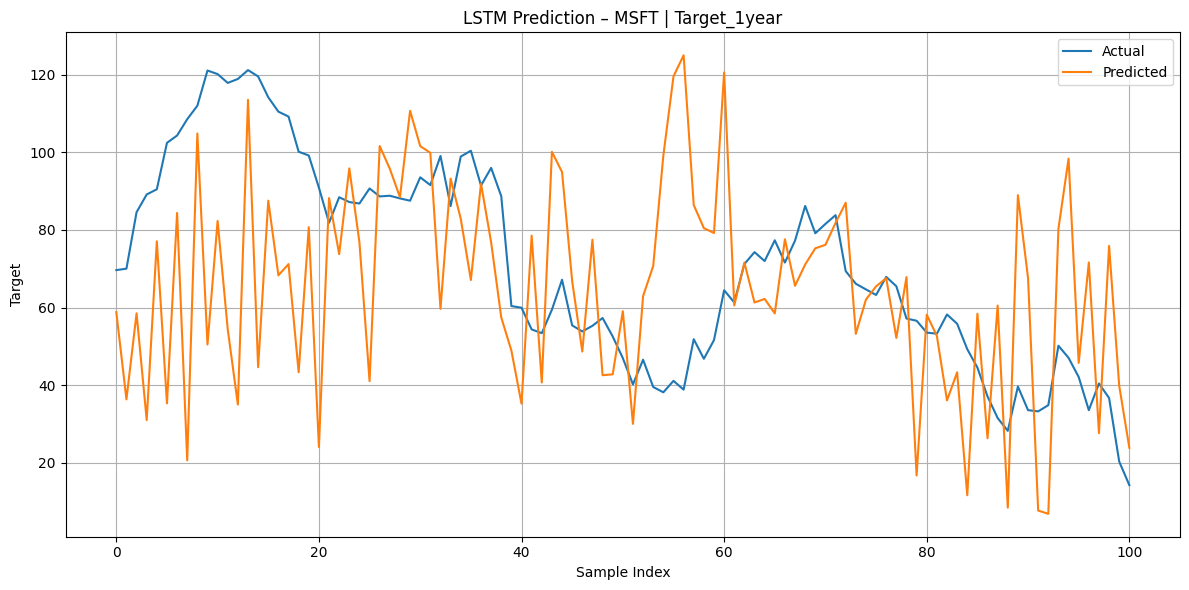

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

[NVDA] Target: Target_1day
MAE : 1.1839
RMSE: 3.2883
R²   : -9.1958


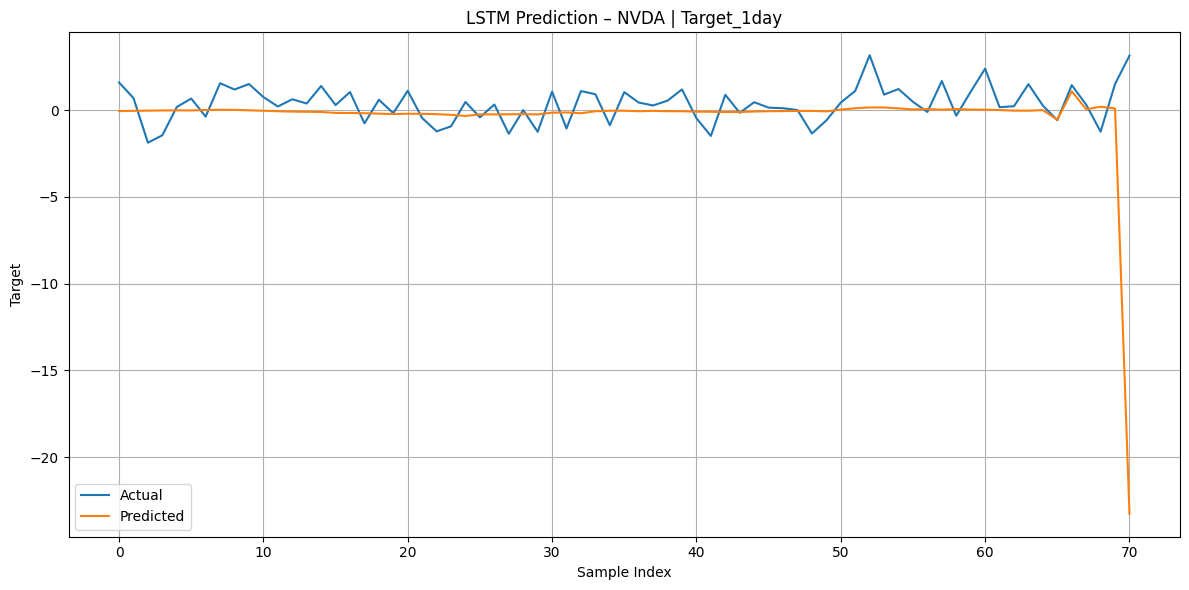

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

[NVDA] Target: Target_1week
MAE : 2.7903
RMSE: 4.0443
R²   : -1.1891


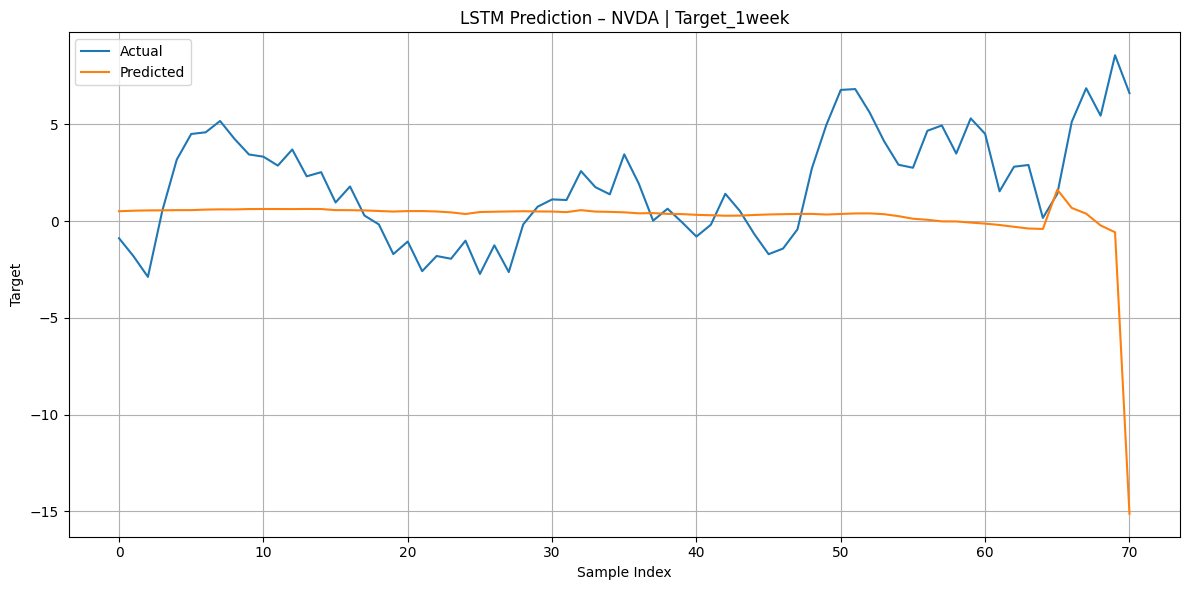

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

[NVDA] Target: Target_1month
MAE : 5.7489
RMSE: 7.2268
R²   : -0.2005


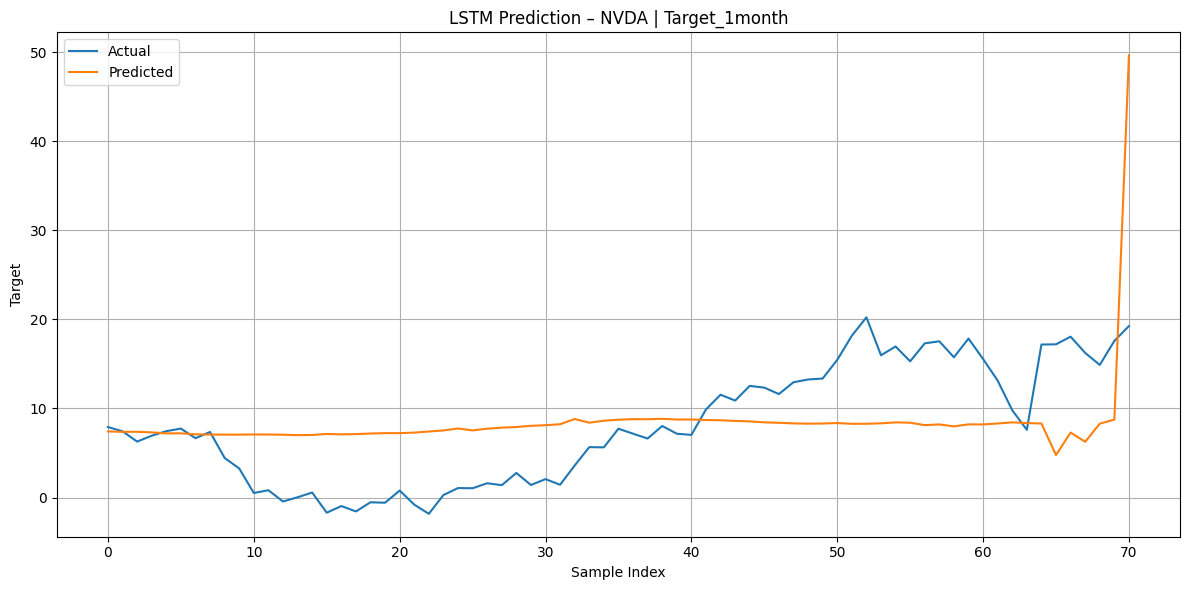

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

[NVDA] Target: Target_1year
MAE : 28.3899
RMSE: 32.6680
R²   : -9.1759


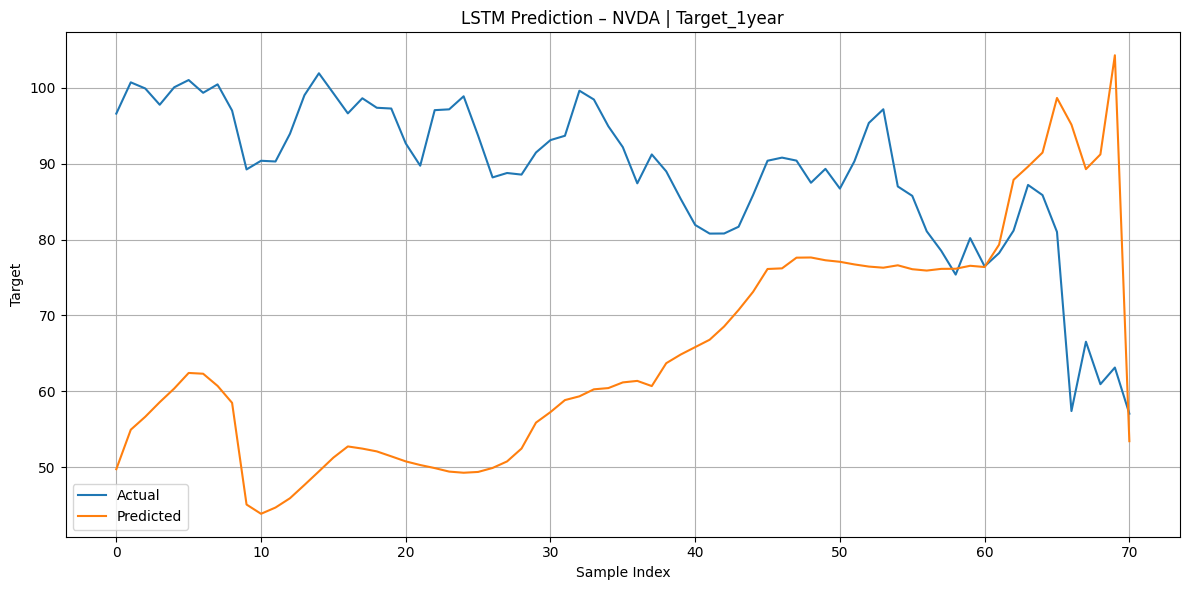

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

[ORCL] Target: Target_1day
MAE : 5.2460
RMSE: 6.7097
R²   : -5.4784


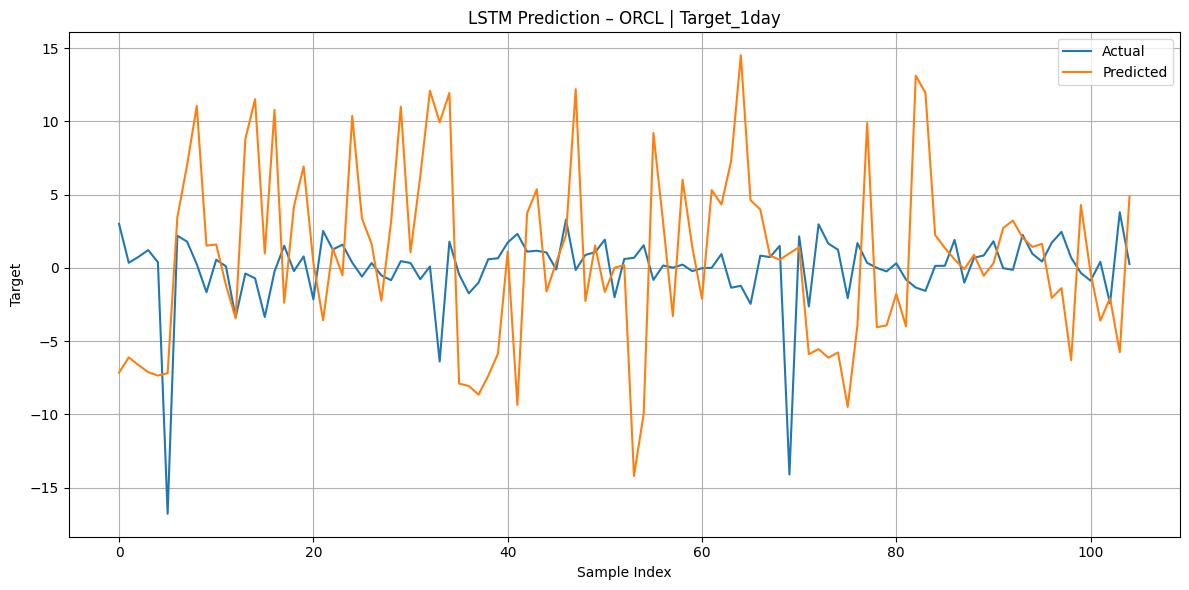

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

[ORCL] Target: Target_1week
MAE : 4.3559
RMSE: 5.5084
R²   : -0.1236


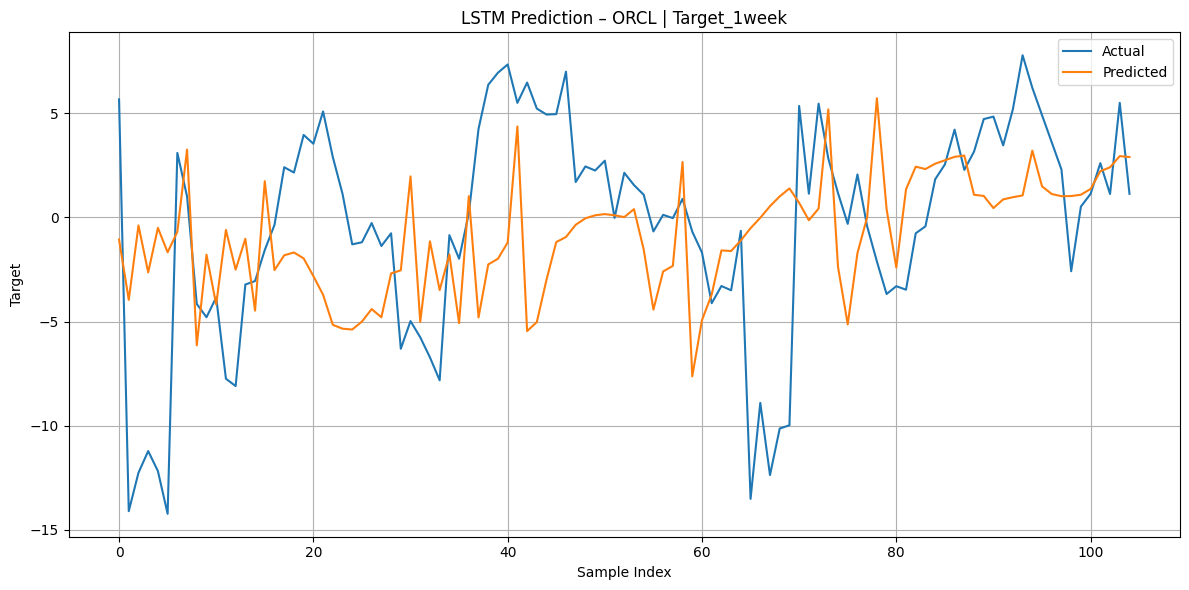

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step

[ORCL] Target: Target_1month
MAE : 9.4054
RMSE: 11.5423
R²   : -0.6531


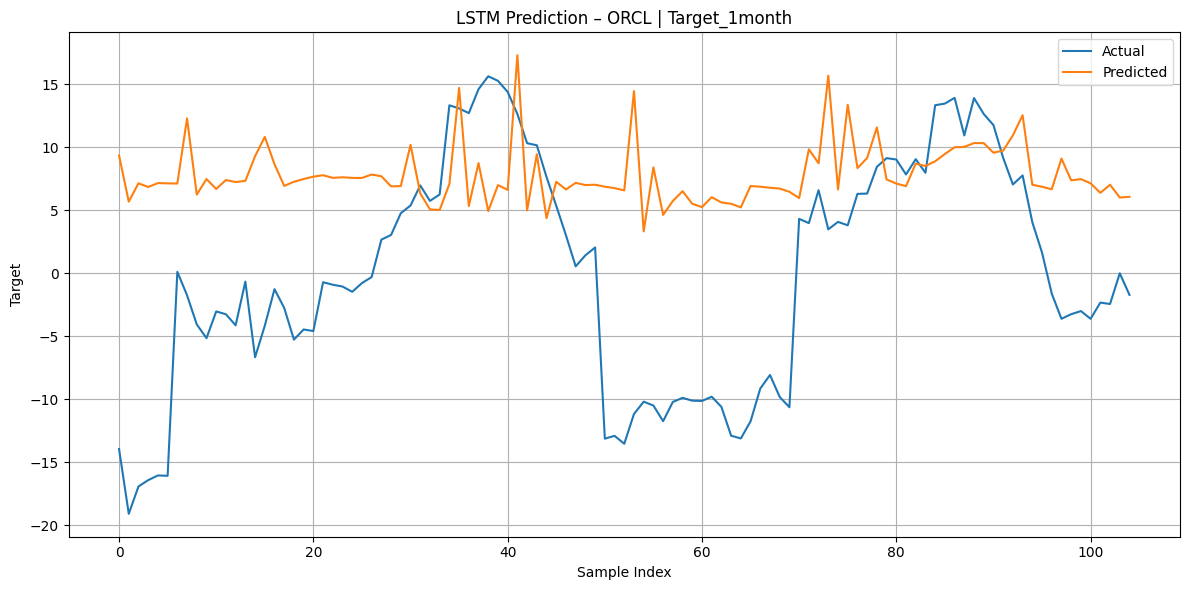

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

[ORCL] Target: Target_1year
MAE : 57.6860
RMSE: 60.4584
R²   : -18.3629


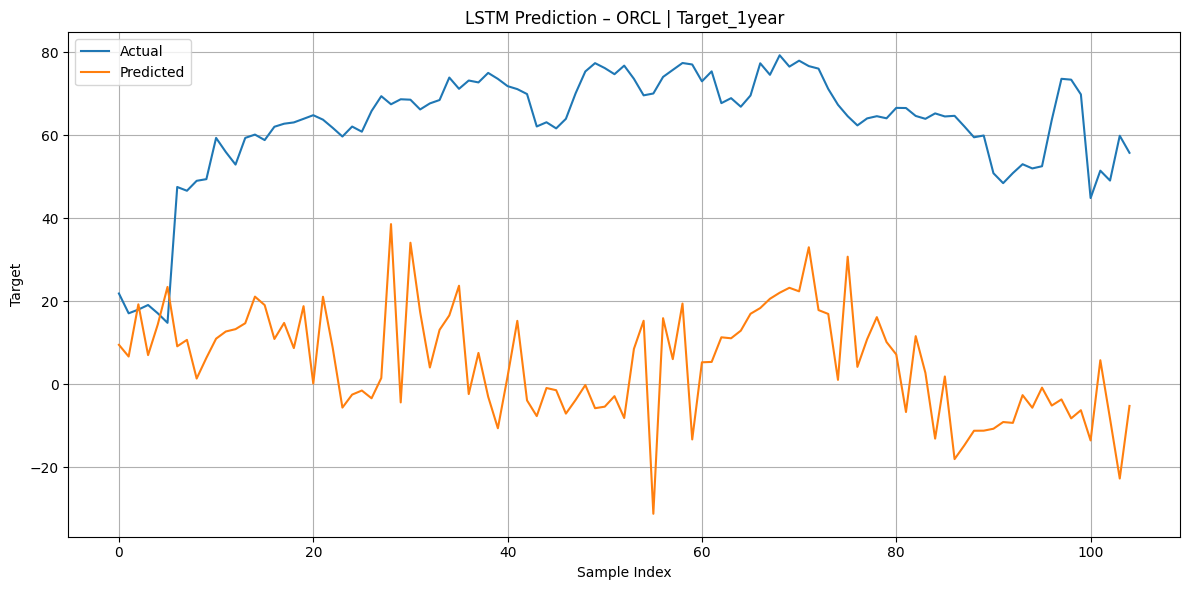

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

[TSLA] Target: Target_1day
MAE : 5.8182
RMSE: 8.1381
R²   : -0.4701


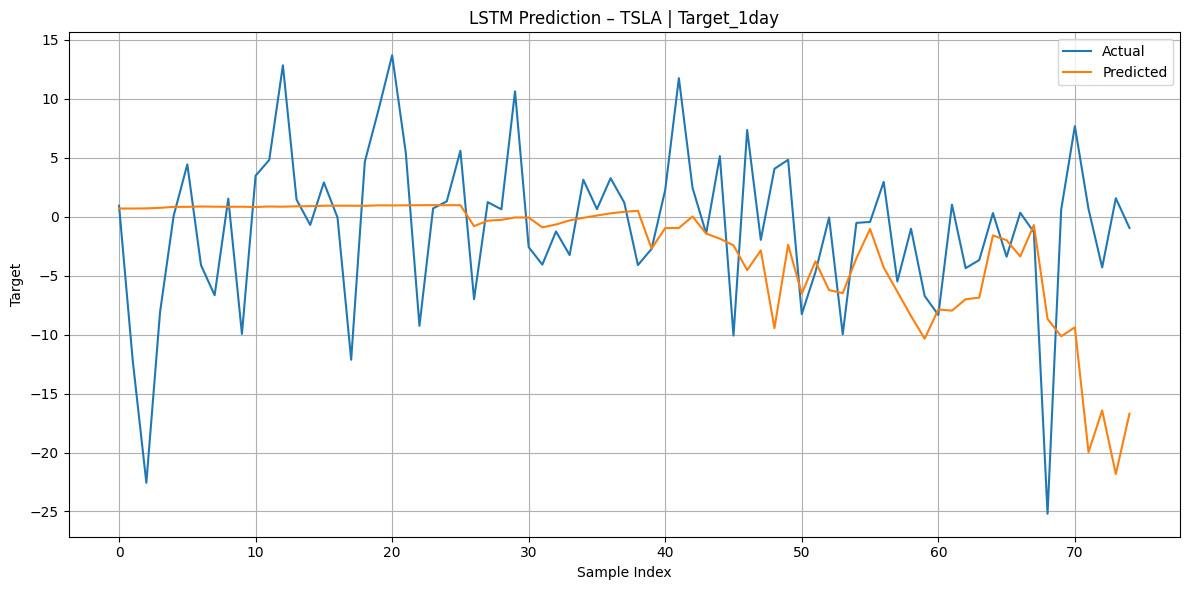

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step

[TSLA] Target: Target_1week
MAE : 11.0716
RMSE: 14.3603
R²   : -0.0079


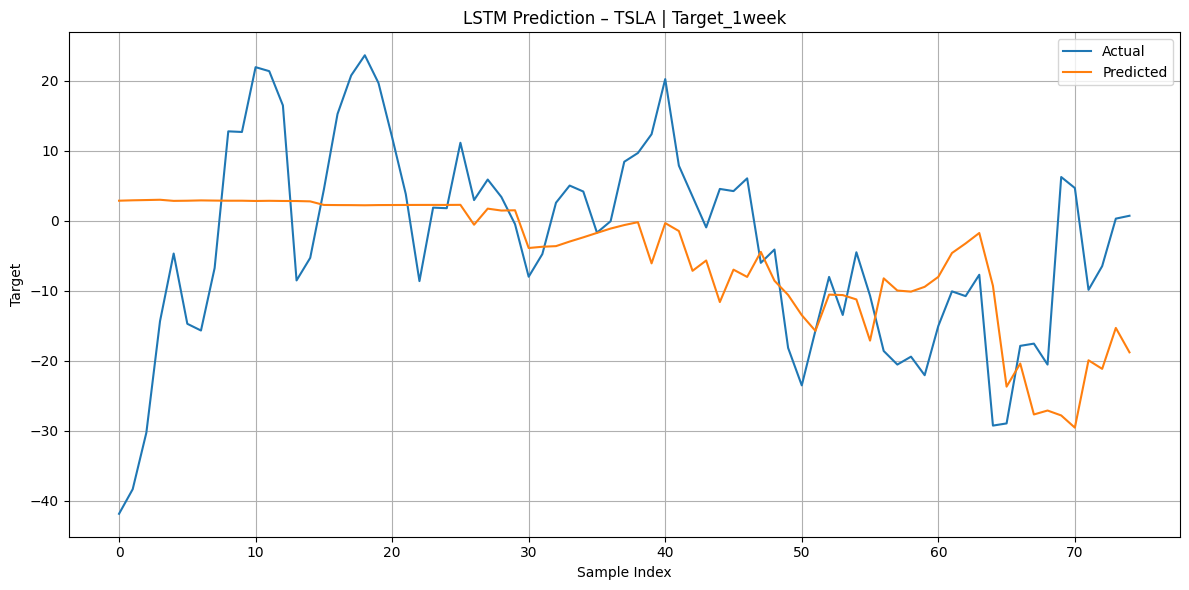

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

[TSLA] Target: Target_1month
MAE : 31.4703
RMSE: 38.3030
R²   : -0.5735


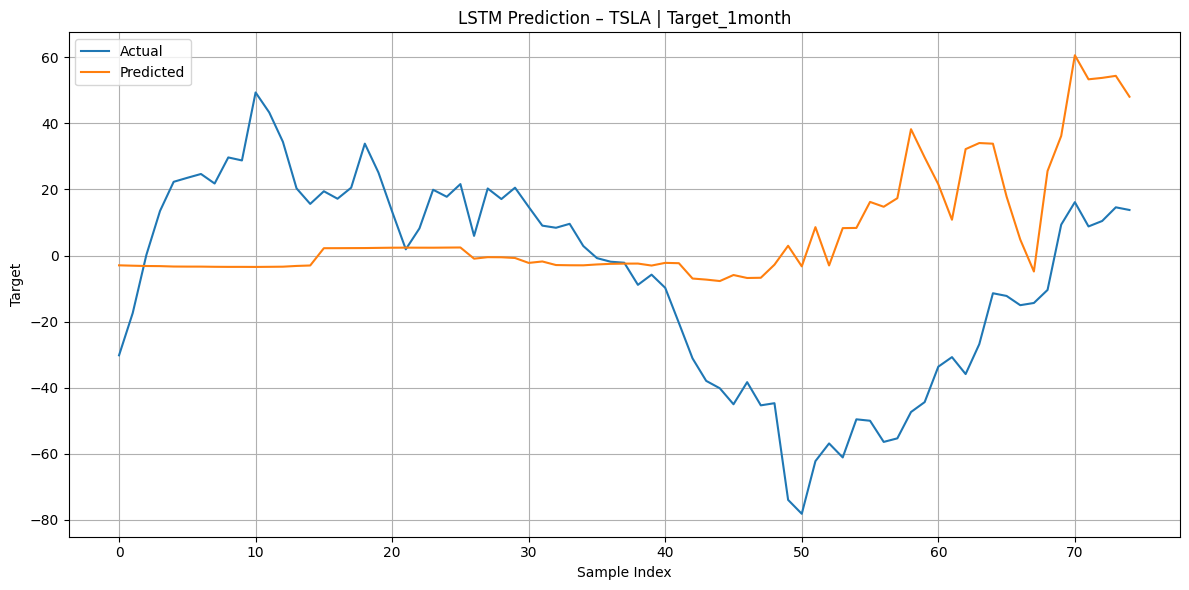

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

[TSLA] Target: Target_1year
MAE : 124.9695
RMSE: 140.0774
R²   : -2.8231


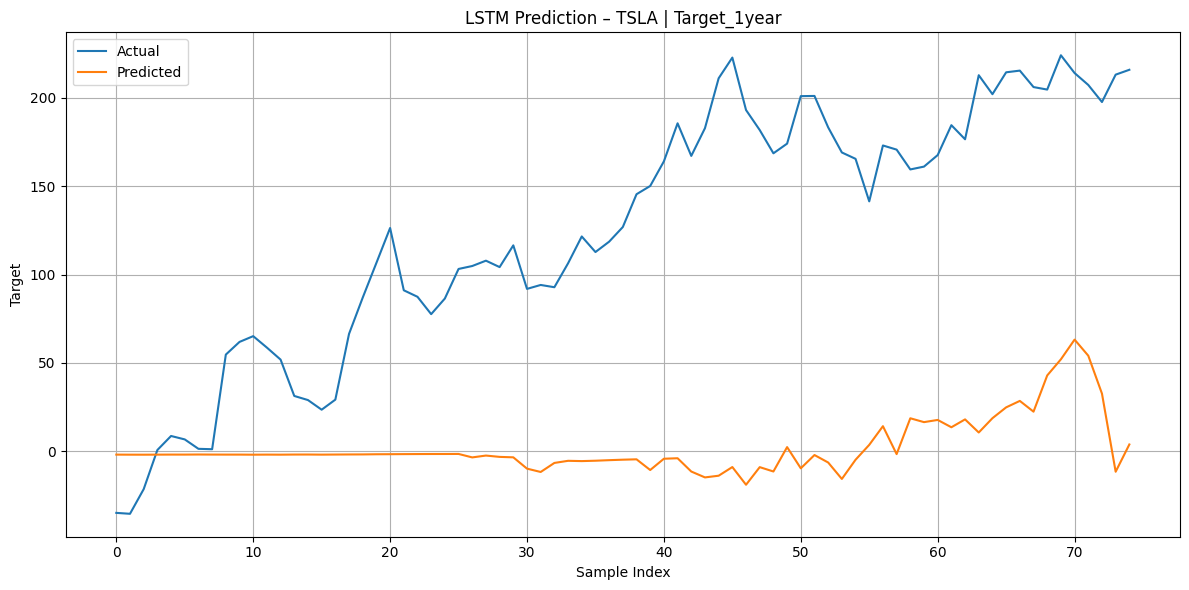

In [46]:
tickers_to_run = df['Ticker'].unique()
targets = ['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']

for ticker in tickers_to_run:
    for target in targets:
        run_lstm_by_ticker(df, ticker, target)
